## Unsupervised Anomaly Detection in Multivariate Time Series

### Dataset 2 - Pump Breakdown Dataset
- Data is taken from a pump PdM dataset on Kaggle (https://www.kaggle.com/nphantawee/pump-sensor-data).
- Raw data has 220,320 rows.
- 52x anonymised sensor channels.
- 1x machine health channel (with value of either normal, broken or recovering).
- 1x datetime channel (data is recorded with 1 min timestep).
- Goal is identify the breakdown periods & any signs of degradtion pre-breakdown.

**Models Evaluated**: 
* MODEL 1. PCA with Mahalonobis Distance
* MODEL 2. K-means Clustering with Euclidean Distance
* MODEL 3. One-class Support Vector Machine (SVM)
* MODEL 4. Isolation Forest
* MODEL 5. LSTM Autoencoder

In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # plotting
import PdM_functions as pdm # custom functions created for this project that are used in several notebooks
import seaborn as sns
sns.set_style('ticks')

### Data Understanding

#### Load Data

In [356]:
# Water pump sensor data (via Kaggle datasets)
selected_fp = 'data/Pump Sensors/sensor.csv'
df_raw = pd.read_csv(selected_fp, sep = ",")
df_raw['timestamp'].head(3)

0    2018-04-01 00:00:00
1    2018-04-01 00:01:00
2    2018-04-01 00:02:00
Name: timestamp, dtype: object

#### Data Quality Report

In [357]:
df_raw.describe()

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,220320.000000,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,110159.500000,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,...,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,63601.049991,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,...,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,55079.750000,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,110159.500000,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,165239.250000,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,219.907400,216.724500
max,220319.000000,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


In [358]:
# Print a data quality report for the numeric data
pdm.generate_dq_num(df_raw.drop(['timestamp', 'machine_status'], axis=1), df_raw.columns.drop(['timestamp', 'machine_status']))

/Users/jasonpayne/opt/anaconda3/envs/pdm/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,Data Type,Missing Values,Unique Values,Min Value,Mean Value,Median Value,Max Value
Unnamed: 0,int64,0,220320,0,110159.500000,110159.500000,220319
sensor_00,float64,10208,1253,0.0,2.372221,2.456539,2.549016
sensor_01,float64,369,831,0.0,47.591611,48.133678,56.72743
sensor_02,float64,19,831,33.15972,50.867392,51.649300,56.03299
sensor_03,float64,19,588,31.64062,43.752481,44.227428,48.22049
sensor_04,float64,19,7844,2.798032,590.673936,632.638916,800.0
sensor_05,float64,19,190751,0.0,73.396414,75.576790,99.99988
sensor_06,float64,4798,812,0.014468,13.501537,13.642940,22.25116
sensor_07,float64,5451,531,0.0,15.843152,16.167530,23.59664
sensor_08,float64,5107,626,0.028935,15.200721,15.494790,24.34896


In [359]:
# Convert timestamp to datetime datatype & sort
df_raw = df_raw.drop('Unnamed: 0', axis = 1)\
  .assign(timestamp = lambda x: pd.to_datetime(x['timestamp'], format = '%Y-%m-%d %H:%M:%S'))\
  .sort_values(by = 'timestamp')

In [360]:
# Assign the timestamp as index for easier plotting
df_raw.index = df_raw['timestamp']

/var/folders/16/mk9d3_3x2xb_bngk3jnsgvw80000gn/T/ipykernel_7007/1640385121.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (18, 4))


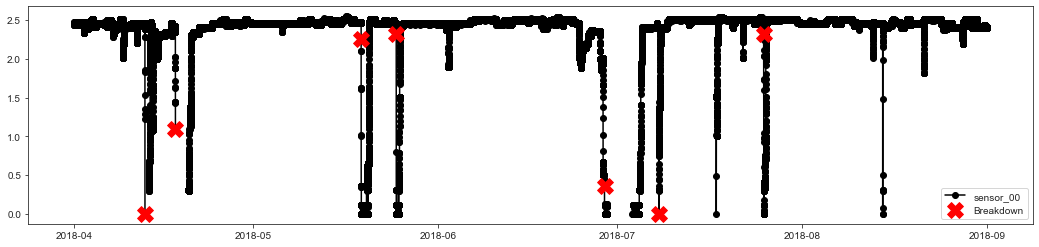

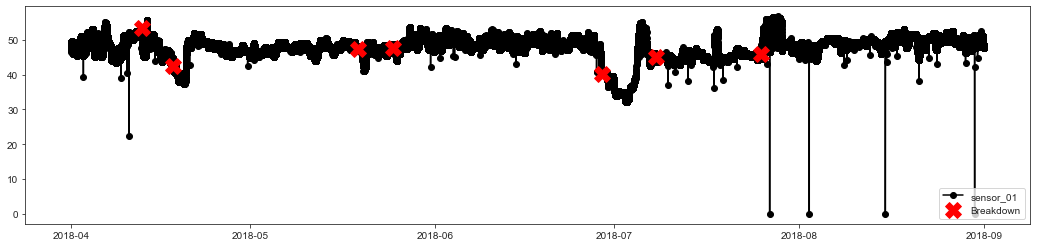

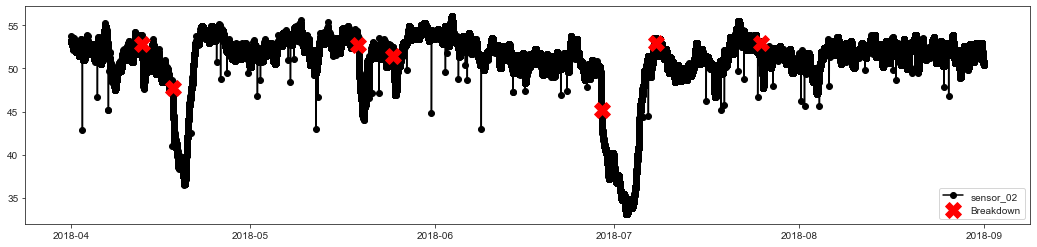

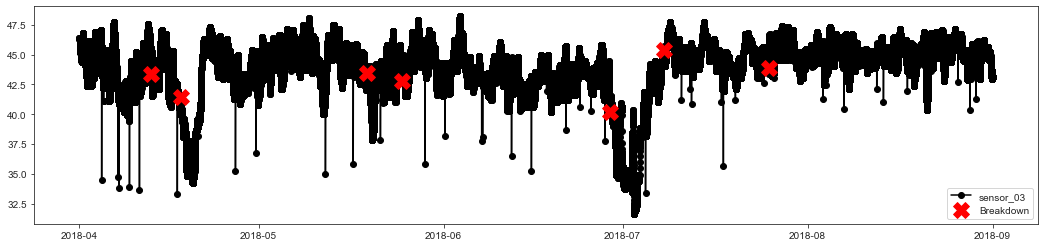

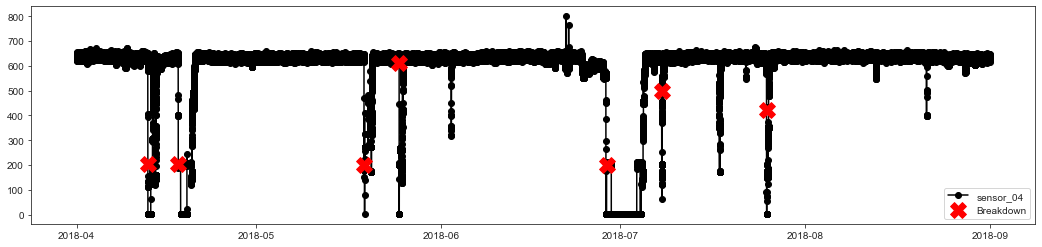

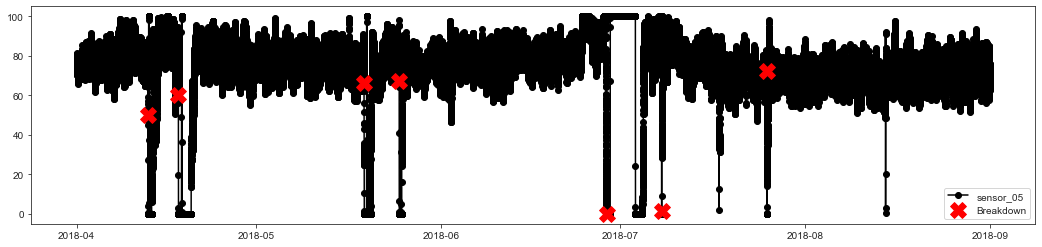

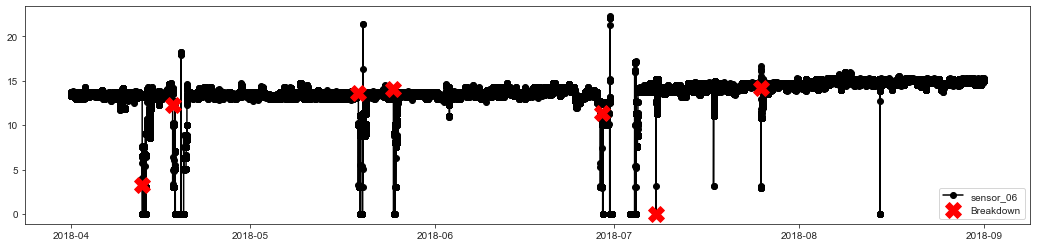

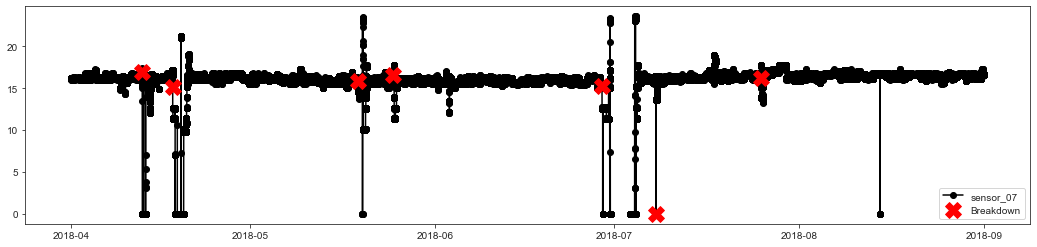

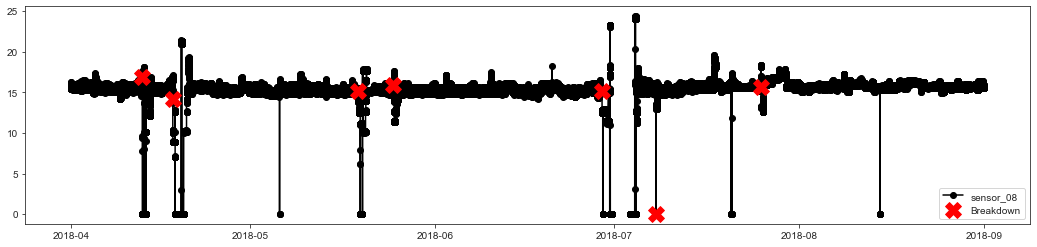

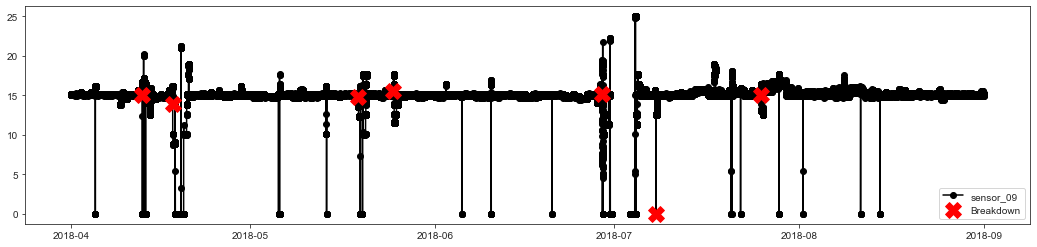

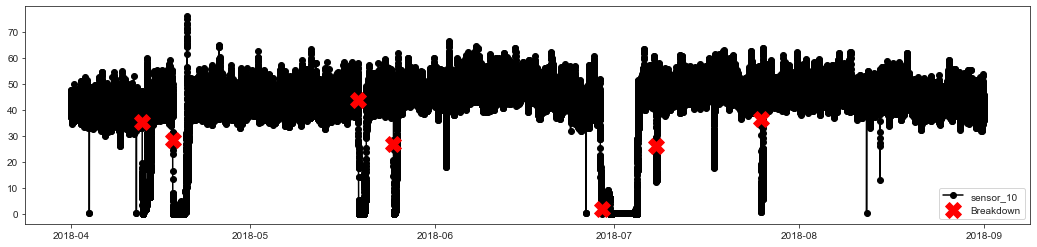

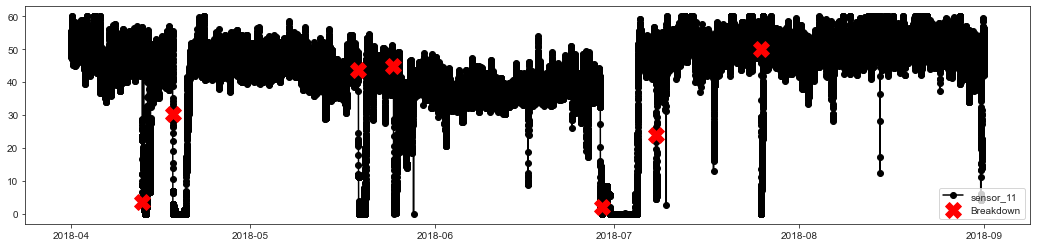

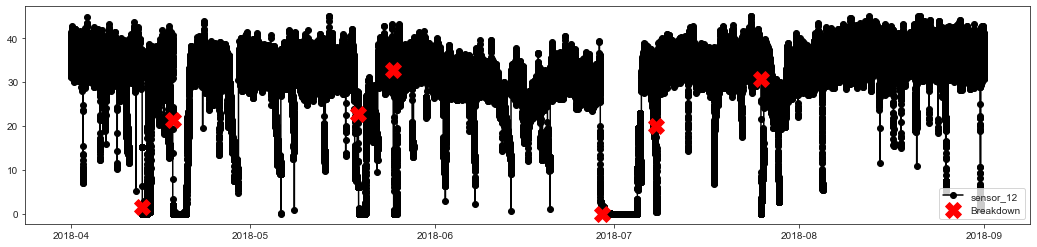

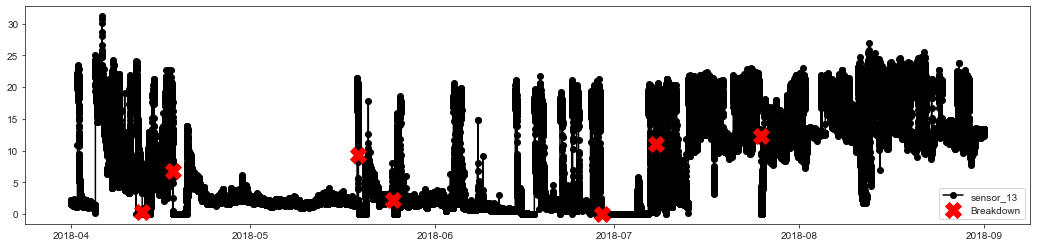

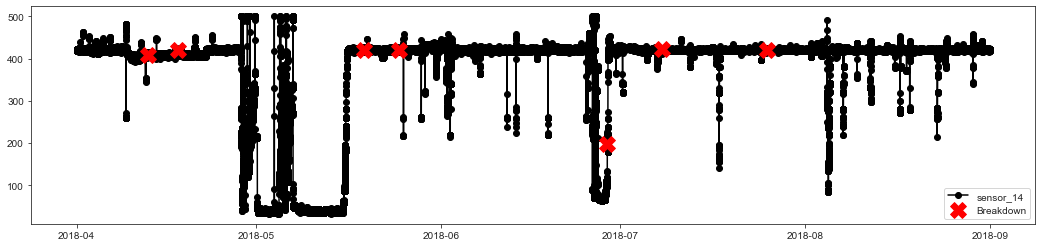

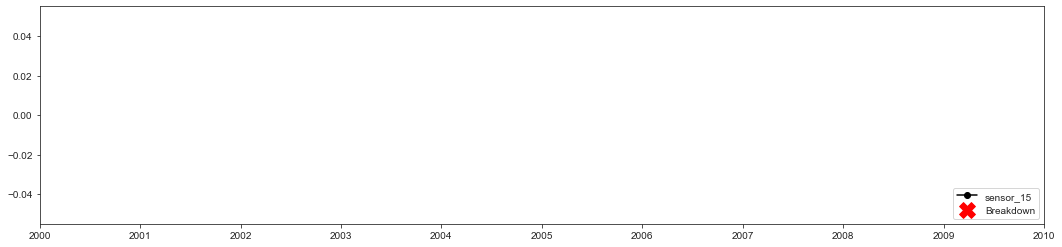

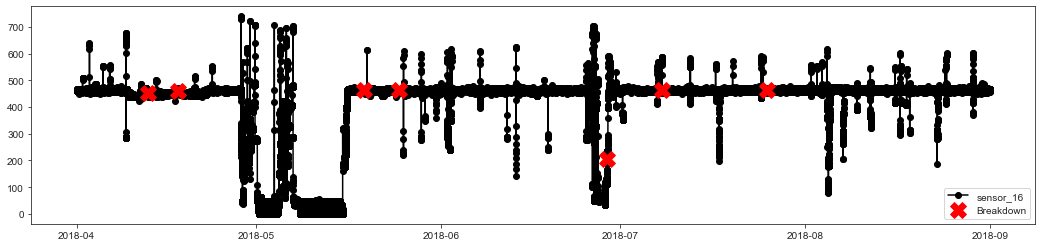

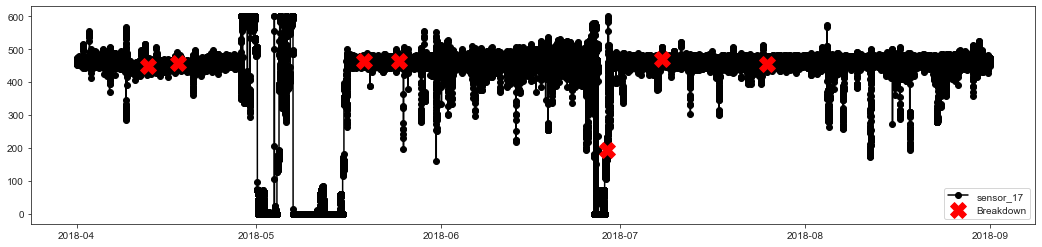

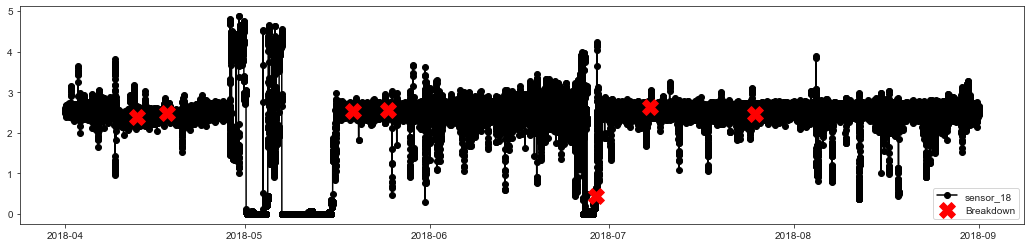

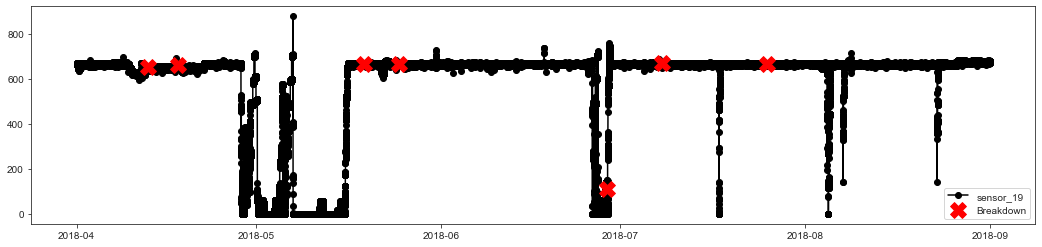

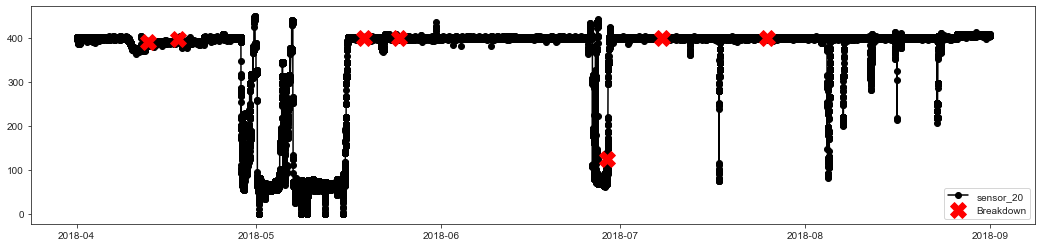

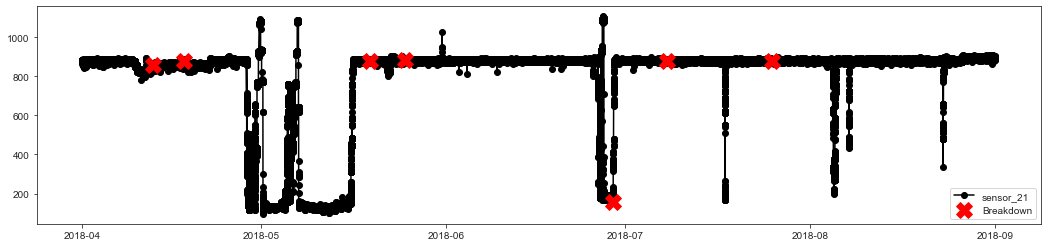

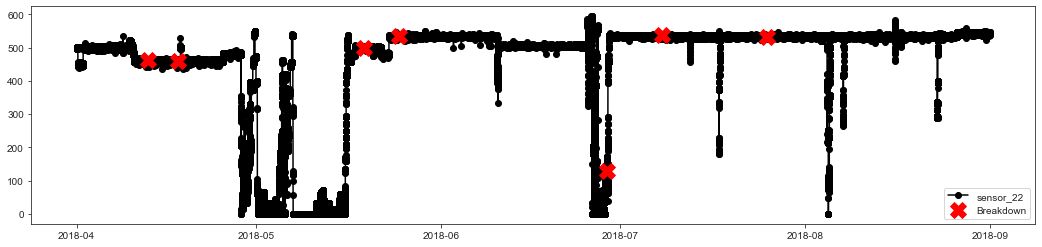

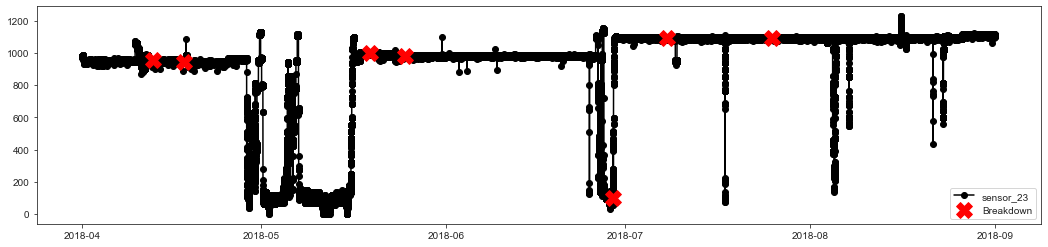

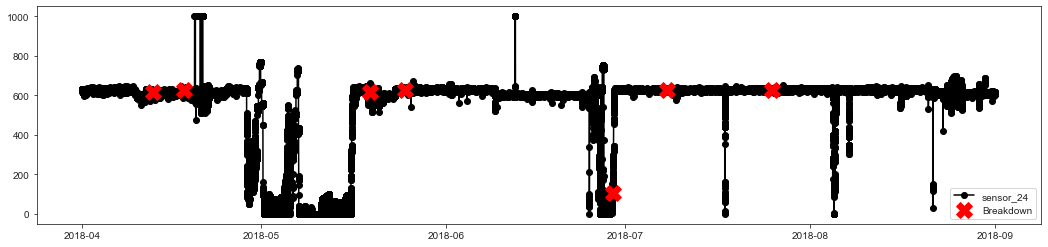

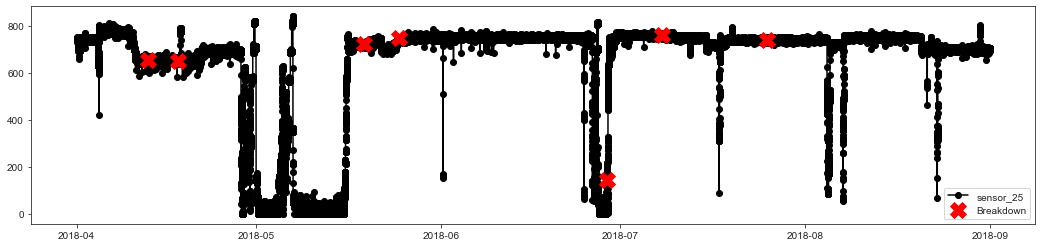

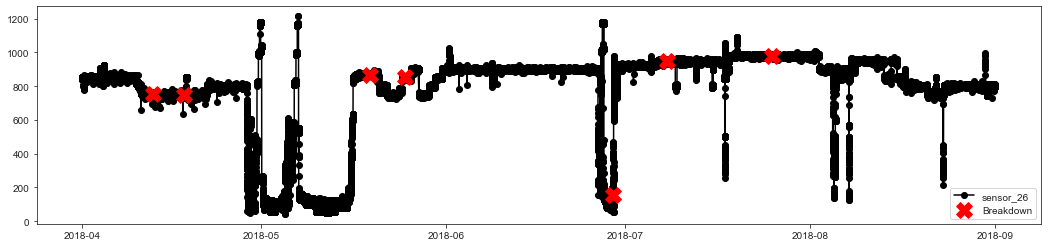

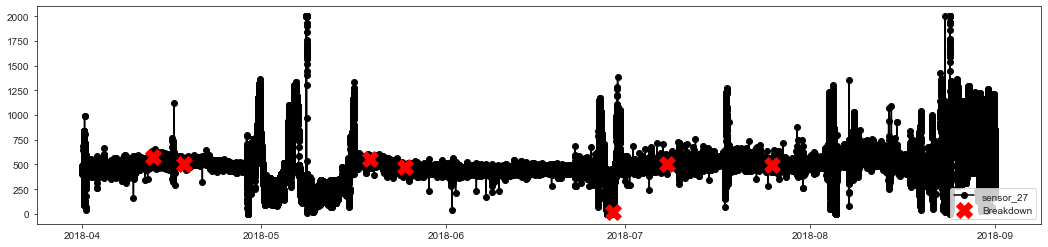

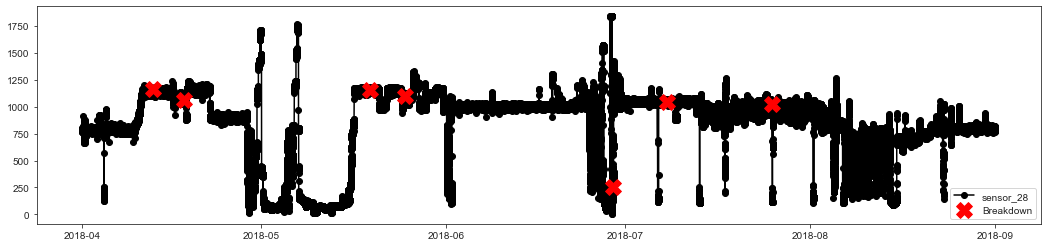

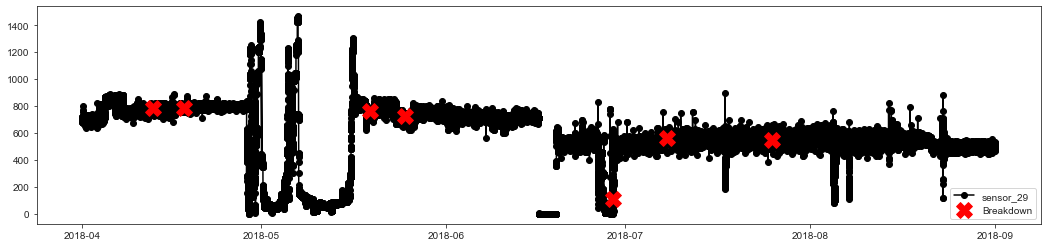

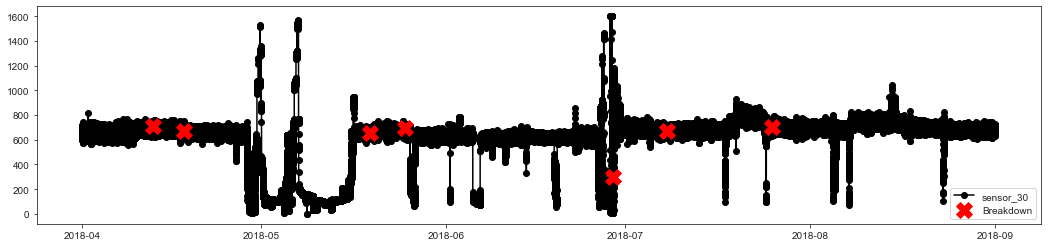

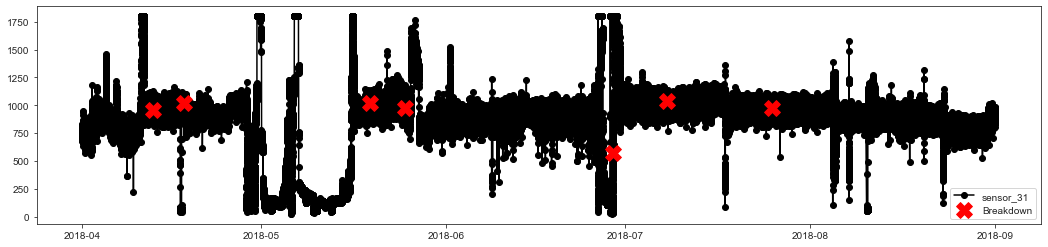

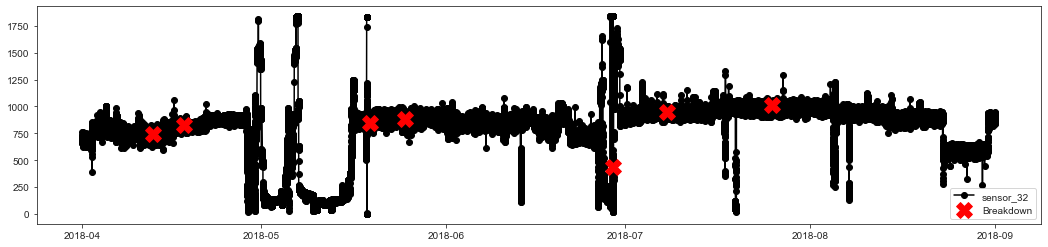

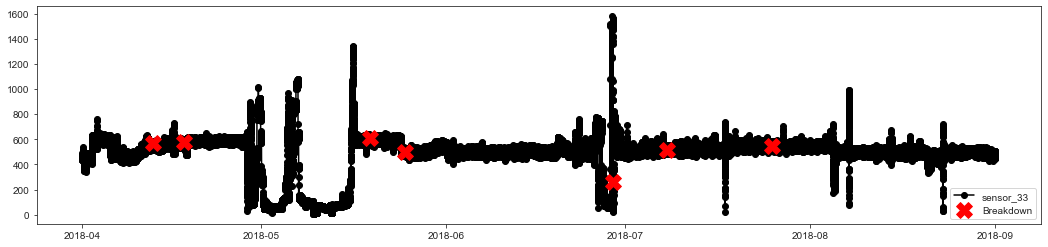

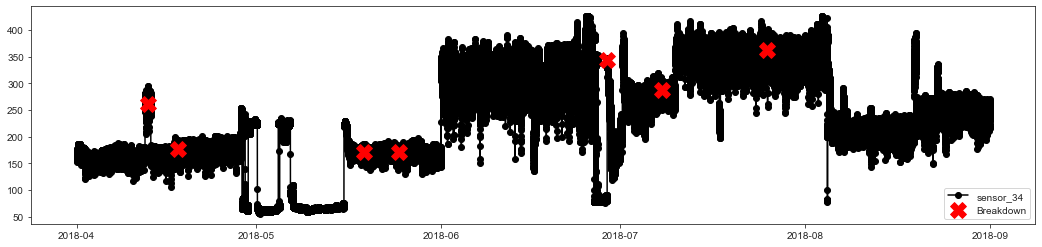

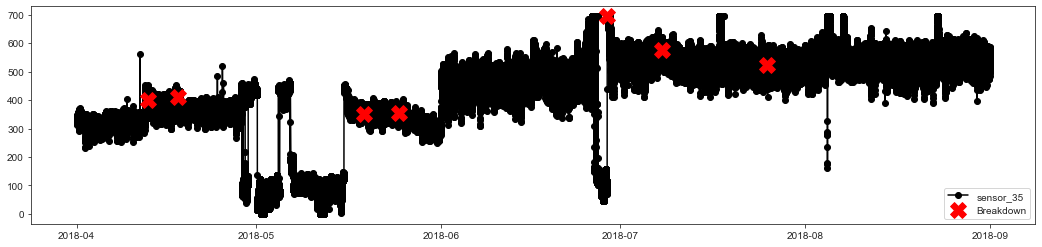

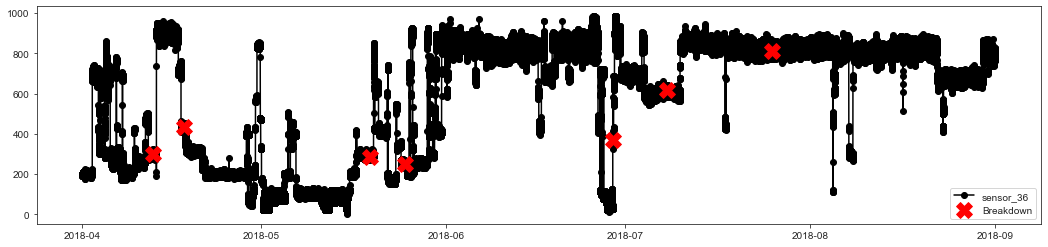

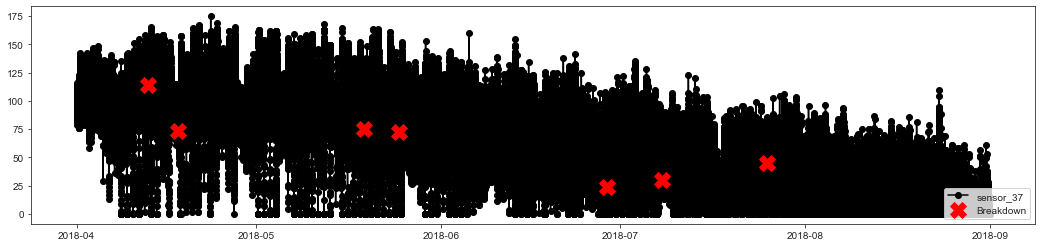

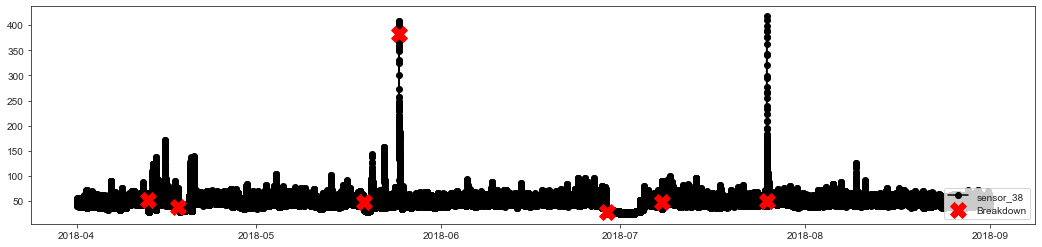

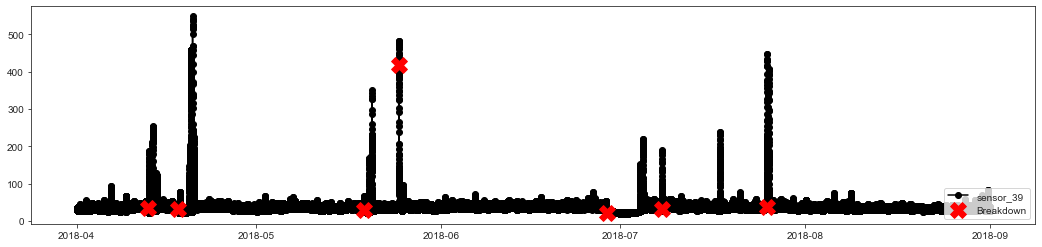

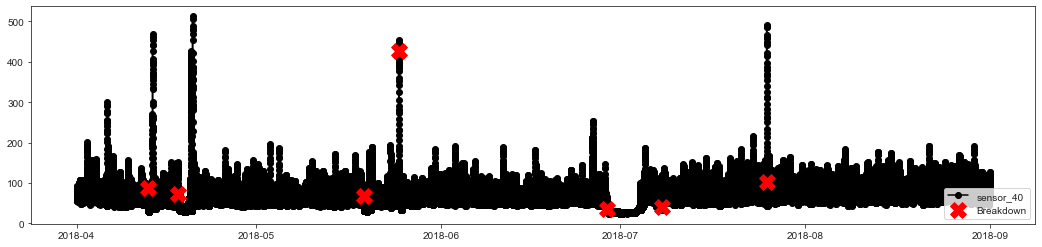

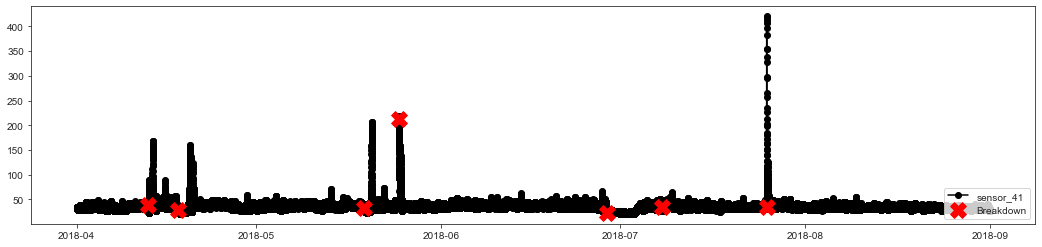

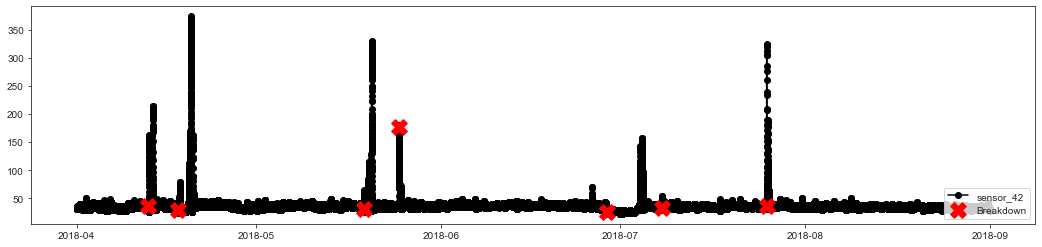

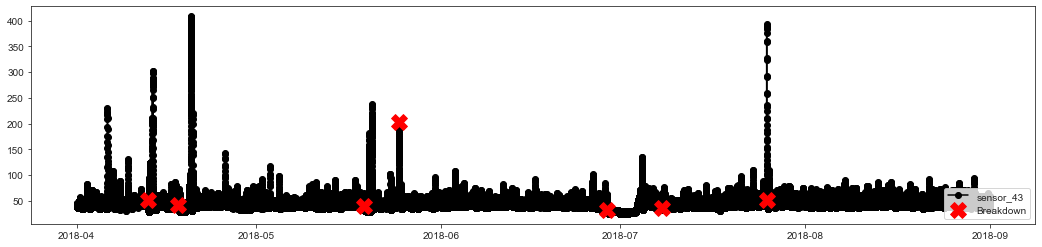

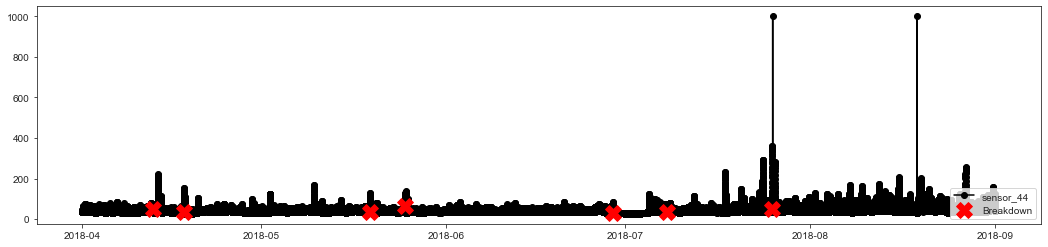

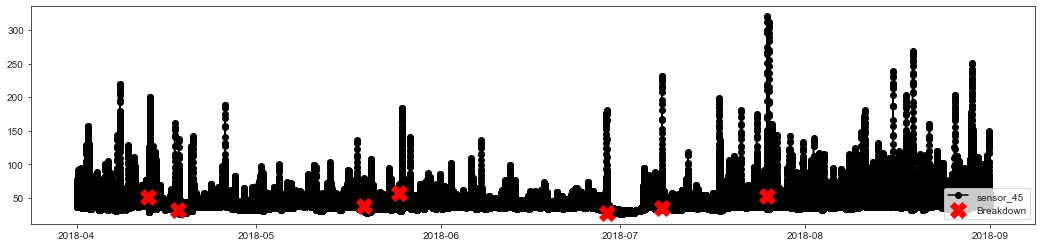

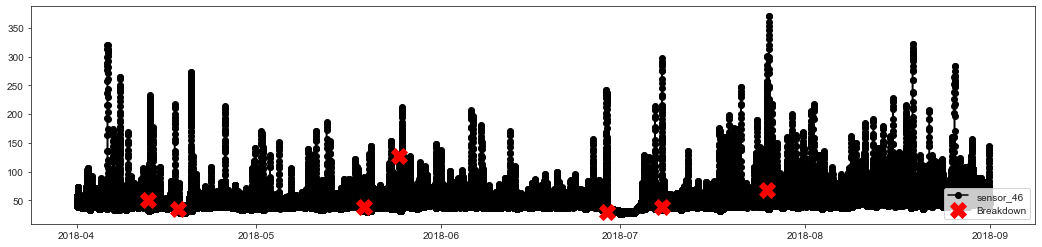

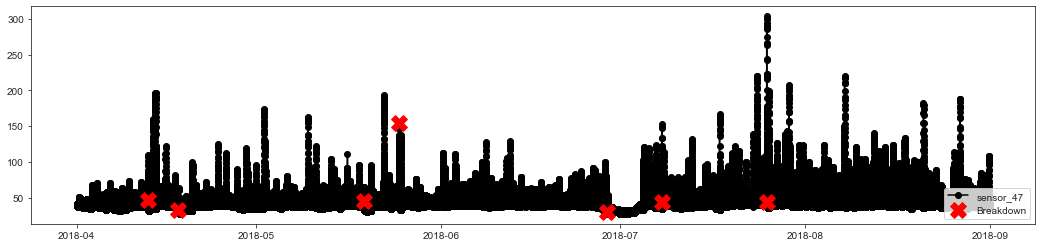

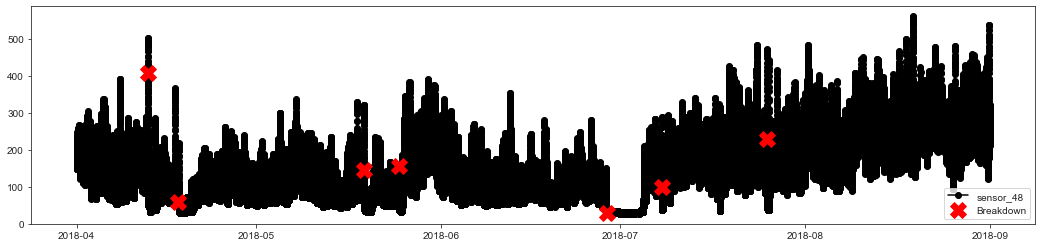

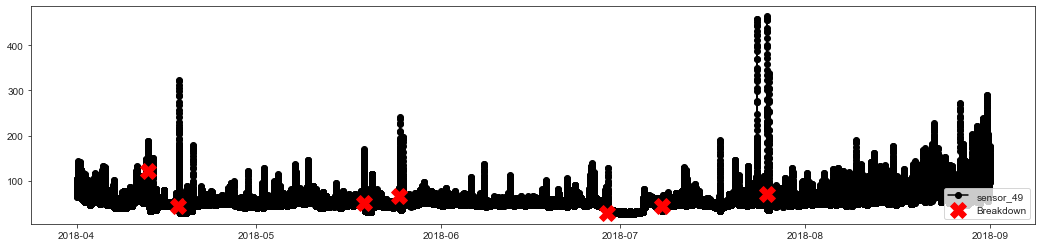

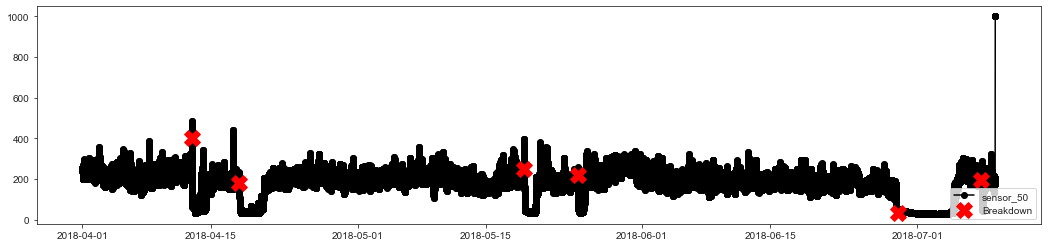

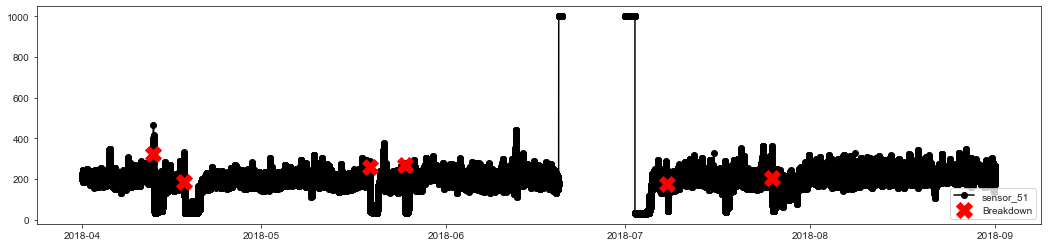

In [361]:
# Plot the data & mark breakdowns with red 'X'
breakdowns = df_raw[df_raw.machine_status == 'BROKEN']
for chan in df_raw.columns[1:-1]:
    fig, ax = plt.subplots(figsize = (18, 4))
    ax.plot(df_raw[chan], color = 'black', marker = 'o', zorder = 1, label = chan)
    ax.scatter(breakdowns.index, breakdowns[chan], color ='red', marker = 'X', zorder = 3, s = 250, label = 'Breakdown')
    ax.legend(loc = 'lower right')
plt.show()

We will use the above plots later in data preparation, i.e., to help cut back on features.

In [362]:
# Check that there are no (time) gaps in the dataset
chk_timestep = df_raw.copy(deep=True).timestamp.diff()[1:]
chk_timestep.reset_index(drop=True, inplace=True)
print('Unique timesteps are ', chk_timestep.astype(str).unique())

Unique timesteps are  ['0 days 00:01:00']


The timestep is 1 minute and consistent through the dataset

In [242]:
# Check on machine status values
print('Reported status types: ', df_raw['machine_status'].unique())

Reported status types:  ['NORMAL' 'BROKEN' 'RECOVERING']


In [243]:
# Print a detailed breakdown of NAs
pdm.check_for_nas(df_raw)

timestamp has 0 NAs			0.0%
sensor_00 has 10208 NAs			4.63%
sensor_01 has 369 NAs			0.17%
sensor_02 has 19 NAs			0.01%
sensor_03 has 19 NAs			0.01%
sensor_04 has 19 NAs			0.01%
sensor_05 has 19 NAs			0.01%
sensor_06 has 4798 NAs			2.18%
sensor_07 has 5451 NAs			2.47%
sensor_08 has 5107 NAs			2.32%
sensor_09 has 4595 NAs			2.09%
sensor_10 has 19 NAs			0.01%
sensor_11 has 19 NAs			0.01%
sensor_12 has 19 NAs			0.01%
sensor_13 has 19 NAs			0.01%
sensor_14 has 21 NAs			0.01%
sensor_15 has 220320 NAs			100.0%
sensor_16 has 31 NAs			0.01%
sensor_17 has 46 NAs			0.02%
sensor_18 has 46 NAs			0.02%
sensor_19 has 16 NAs			0.01%
sensor_20 has 16 NAs			0.01%
sensor_21 has 16 NAs			0.01%
sensor_22 has 41 NAs			0.02%
sensor_23 has 16 NAs			0.01%
sensor_24 has 16 NAs			0.01%
sensor_25 has 36 NAs			0.02%
sensor_26 has 20 NAs			0.01%
sensor_27 has 16 NAs			0.01%
sensor_28 has 16 NAs			0.01%
sensor_29 has 72 NAs			0.03%
sensor_30 has 261 NAs			0.12%
sensor_31 has 16 NAs			0.01%
sensor_32 has 68 NAs			0.03

sensor_15, 50 and 51 contain a large number of NAs.  Consider dropping for this assessment.

#### Data Distributions

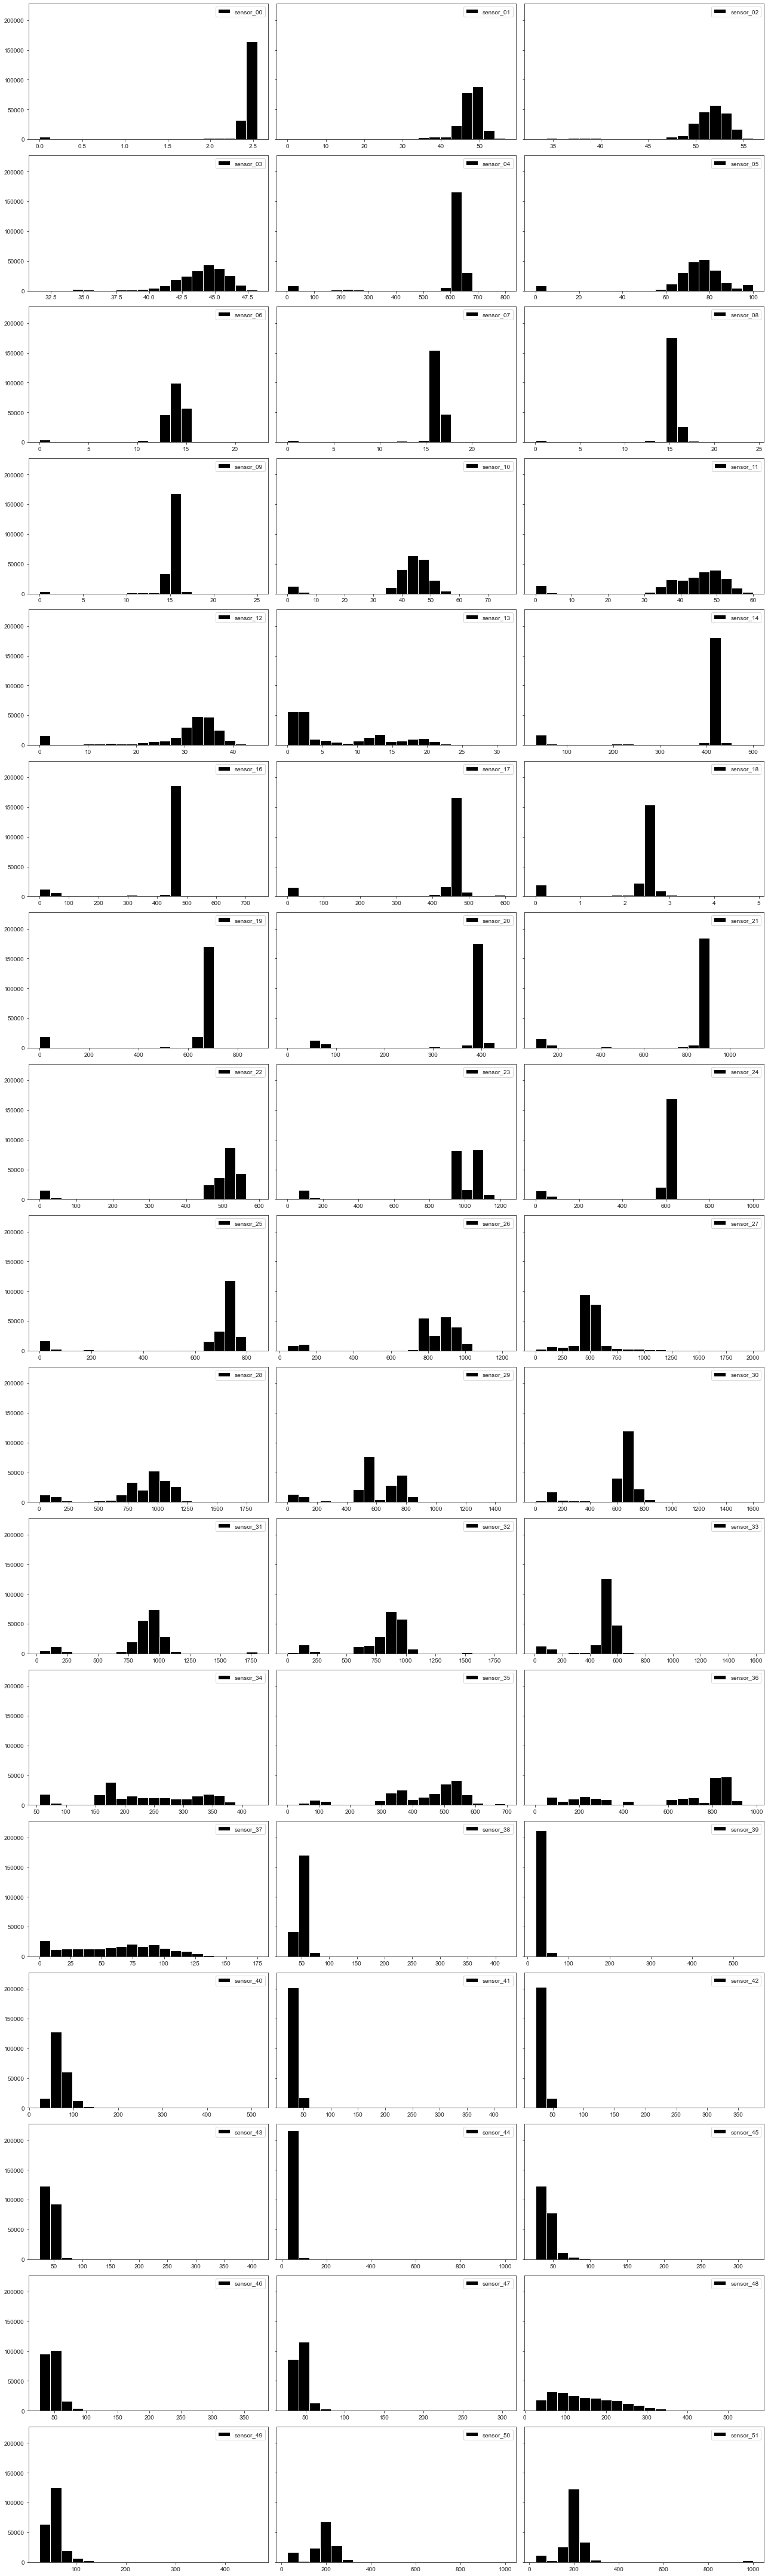

In [244]:
n_bins = 20
fig, axs = plt.subplots(17, 3, sharey=True, tight_layout=True, figsize = (18, 60))
axs = axs.ravel()
drops = ['timestamp', 'machine_status', 'sensor_15']
for p, ref in enumerate(df_raw.columns.drop(drops)):
    axs[p].hist(df_raw[ref].values, bins=n_bins, label = ref, color = 'black')
    axs[p].legend(loc = 'upper right')

Most channels have outliers.  Some unusual distributions.    

#### Correlations

Not practical to generate a scatter plot matrix due to the number of features (52).  Let's use a correlation matrix and heatmap for investigation. 

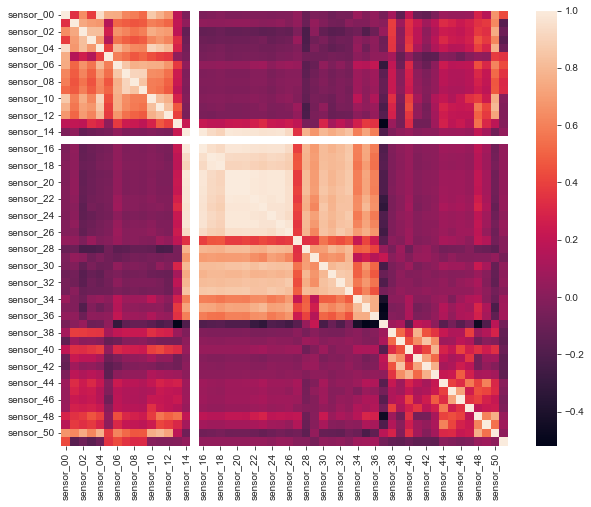

In [246]:
# Plot correlation heatmap
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
dataplot = sns.heatmap(df_raw.corr(method='pearson'))
plt.show()

Several features are strongly correlated with each other.

In [373]:
# Let's plot a table for a selection of closely correlated features
df_raw[['sensor_14','sensor_16','sensor_17','sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 
        'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28']]\
.corr(method='pearson', min_periods=1)

,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28
sensor_14,1.000000,0.990359,0.930189,0.901102,0.983039,0.979983,0.971702,0.972273,0.961549,0.964923,0.972093,0.928108,0.346368,0.778832
sensor_16,0.990359,1.000000,0.952222,0.925335,0.979602,0.976890,0.973488,0.968103,0.958821,0.965954,0.968225,0.930129,0.390118,0.792102
sensor_17,0.930189,0.952222,1.000000,0.983326,0.930701,0.925823,0.928197,0.919987,0.905537,0.925948,0.916971,0.887343,0.455152,0.779042
sensor_18,0.901102,0.925335,0.983326,1.000000,0.907559,0.906449,0.911878,0.896953,0.885642,0.904009,0.896609,0.877982,0.463414,0.770517
sensor_19,0.983039,0.979602,0.930701,0.907559,1.000000,0.998227,0.995974,0.988217,0.978689,0.985606,0.984769,0.950021,0.382500,0.806514
sensor_20,0.979983,0.976890,0.925823,0.906449,0.998227,1.000000,0.997075,0.986531,0.979060,0.983975,0.984240,0.951891,0.382229,0.808100
sensor_21,0.971702,0.973488,0.928197,0.911878,0.995974,0.997075,1.000000,0.984222,0.978461,0.984926,0.982318,0.954364,0.402029,0.814952
sensor_22,0.972273,0.968103,0.919987,0.896953,0.988217,0.986531,0.984222,1.000000,0.986869,0.975862,0.982483,0.956325,0.382315,0.774450
sensor_23,0.961549,0.958821,0.905537,0.885642,0.978689,0.979060,0.978461,0.986869,1.000000,0.967019,0.970222,0.955338,0.418817,0.759202
sensor_24,0.964923,0.965954,0.925948,0.904009,0.985606,0.983975,0.984926,0.975862,0.967019,1.000000,0.969931,0.939070,0.392759,0.805384


Take this into consideration during feature reduction as part of data preparation.

### Data Preparation

In [374]:
# Drop columns with high degress of missingness
df_set = df_raw.copy(deep=True).drop(['sensor_15', 'sensor_50', 'sensor_51'], axis = 1)

# Replace NAs in remaining data by using last value fill forward method
df_set = df_set.fillna(method = 'ffill')

In [375]:
# Check for NAs again (to verify fill NA has worked)
pdm.check_for_nas(df_set)

timestamp has 0 NAs			0.0%
sensor_00 has 0 NAs			0.0%
sensor_01 has 0 NAs			0.0%
sensor_02 has 0 NAs			0.0%
sensor_03 has 0 NAs			0.0%
sensor_04 has 0 NAs			0.0%
sensor_05 has 0 NAs			0.0%
sensor_06 has 0 NAs			0.0%
sensor_07 has 0 NAs			0.0%
sensor_08 has 0 NAs			0.0%
sensor_09 has 0 NAs			0.0%
sensor_10 has 0 NAs			0.0%
sensor_11 has 0 NAs			0.0%
sensor_12 has 0 NAs			0.0%
sensor_13 has 0 NAs			0.0%
sensor_14 has 0 NAs			0.0%
sensor_16 has 0 NAs			0.0%
sensor_17 has 0 NAs			0.0%
sensor_18 has 0 NAs			0.0%
sensor_19 has 0 NAs			0.0%
sensor_20 has 0 NAs			0.0%
sensor_21 has 0 NAs			0.0%
sensor_22 has 0 NAs			0.0%
sensor_23 has 0 NAs			0.0%
sensor_24 has 0 NAs			0.0%
sensor_25 has 0 NAs			0.0%
sensor_26 has 0 NAs			0.0%
sensor_27 has 0 NAs			0.0%
sensor_28 has 0 NAs			0.0%
sensor_29 has 0 NAs			0.0%
sensor_30 has 0 NAs			0.0%
sensor_31 has 0 NAs			0.0%
sensor_32 has 0 NAs			0.0%
sensor_33 has 0 NAs			0.0%
sensor_34 has 0 NAs			0.0%
sensor_35 has 0 NAs			0.0%
sensor_36 has 0 NAs			0.0%
s

In [376]:
# Apply some cleaning to df_set based on inspection of the timetrace signals
# S1 displays regular spikes without transition points, clamp these (replace with median)
# Any points less than 28,replace with median
s1_med = df_set['sensor_01'].median()
df_set['sensor_01'] = df_set['sensor_01']\
  .apply(lambda x: s1_med if x in ['nan'] else pdm.clampit(x, cl_lim = 28, cl_val = s1_med, cl_type = 'low'))

# S6 similarly
s6_med = df_set['sensor_06'].median()
df_set['sensor_06'] = df_set['sensor_06']\
  .apply(lambda x: s6_med if x in ['nan'] else pdm.clampit(x, cl_lim = 6, cl_val = s6_med, cl_type = 'low'))\
  .apply(lambda x: s6_med if x in ['nan'] else pdm.clampit(x, cl_lim = 25, cl_val = s6_med, cl_type = 'high'))

# S9 similarly displays some regular spikes that we will assume are spurious
# Any points less than 6 or greater than 21,replace with median
s9_med = df_set['sensor_09'].median()
df_set['sensor_09'] = df_set['sensor_09']\
  .apply(lambda x: s1_med if x in ['nan'] else pdm.clampit(x, cl_lim = 6, cl_val = s9_med, cl_type = 'low'))\
  .apply(lambda x: s1_med if x in ['nan'] else pdm.clampit(x, cl_lim = 21, cl_val = s9_med, cl_type = 'high'))

In [265]:
#df_set.to_csv('data/Pump Sensors/prep_sensor.csv', index=False)

In [377]:
# Reduce the dataset to a more manageable subset
# Iterate on this with modelling to find a performant model
include_cols = [
    'timestamp', 
    'sensor_00',
    'sensor_01',
    'sensor_02',
    'sensor_03',
    'sensor_04',
    'sensor_05',
    'sensor_06',
    #'sensor_07',
    #'sensor_08',
    #'sensor_09',
    'sensor_10',
    ## Break
    #'sensor_38',
    #'sensor_39',
    #'sensor_40',
    #'sensor_41',
    #'sensor_42',
    #'sensor_43',
    #'sensor_44',    
    'machine_status'
]

In [378]:
# Subset data tagged as 'Normal' operating 
df_norm = df_set.loc[df_set['machine_status'] == 'NORMAL', include_cols]  
df_norm['timestamp'] = pd.to_datetime(df_norm.index, format = '%Y-%m-%d %H:%M:%S')

# Subset data tagged as 'Normal' operating 
df_reco = df_set.loc[df_set['machine_status'] == 'RECOVERING', include_cols] 
df_reco['timestamp'] = pd.to_datetime(df_reco.index, format = '%Y-%m-%d %H:%M:%S')

# Subset data tagged as 'Normal' operating 
df_brok = df_set.loc[df_set['machine_status'] == 'BROKEN', include_cols] 
df_brok['timestamp'] = pd.to_datetime(df_brok.index, format = '%Y-%m-%d %H:%M:%S')

#### Plot Events with a Sensor Channel as Backdrop

In [379]:
# Choose a backdrop channel (channel display behind machine status views & anomaly prediction)
backdrop_chan = 'sensor_04'

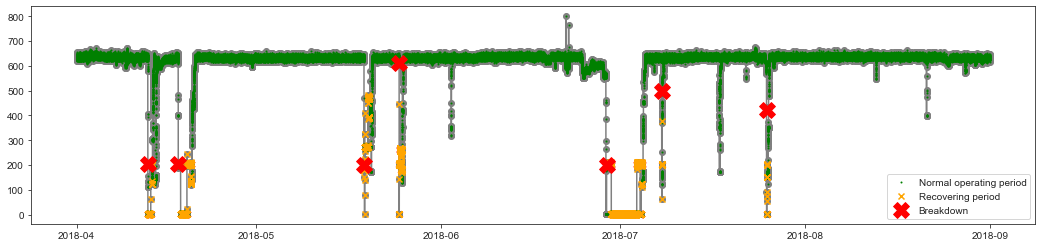

In [380]:
# Visualize machine status over time for the data using backdrop sensor as reference
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(df_set['timestamp'], df_set[backdrop_chan], color = 'grey', marker = 'o', zorder = 1)
ax.scatter(df_norm['timestamp'], df_norm[backdrop_chan], color ='green', marker = 'o', zorder = 2, s = 1, label = 'Normal operating period')
ax.scatter(df_reco['timestamp'], df_reco[backdrop_chan], color ='orange', marker = 'x', zorder = 3, label = 'Recovering period')
ax.scatter(df_brok['timestamp'], df_brok[backdrop_chan], color ='red', marker = 'X', zorder = 3, s = 250, label = 'Breakdown')
ax.legend(loc = 'lower right')
plt.show()

In the plot above, green is normal operating time (as reported), orange zones are when the pump was in a recovering mode and red is the labelled breakdown.  The time series shows 7x recorded failures with recovery periods.  

#### Scale Data

In [381]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from matplotlib import gridspec
from matplotlib.pyplot import figure
from itertools import groupby

In [382]:
# Standardise the data using a standard scaler (mean~0, std ~1)
df_num = df_set.copy(deep=True).drop(['timestamp', 'machine_status'], axis = 1)
scaler = preprocessing.StandardScaler()
df_set_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns = df_num.columns, index = df_num.index)
df_set_scaled['timestamp'] = df_set['timestamp']
df_set_scaled['machine_status'] = df_set['machine_status']
df_set_scaled.describe()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49
count,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,...,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05
mean,7.430512e-17,-4.231264e-16,4.551189e-16,5.263280e-15,-8.091002e-16,-1.562214e-16,5.374737e-15,4.107422e-16,-2.146592e-16,1.444822e-17,...,1.032016e-16,1.139345e-15,2.745161e-16,-1.702826e-16,-5.242639e-16,-2.518118e-16,1.126961e-15,-9.631286e-16,-2.146592e-16,2.229154e-16
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-3.896670e+00,-4.670490e+00,-4.828443e+00,-5.006965e+00,-4.081218e+00,-4.242232e+00,-7.581048e+00,-4.915887e+00,-5.019891e+00,-1.244306e+01,...,-2.124693e+00,-1.839810e+00,-1.298159e+00,-1.756631e+00,-1.460291e+00,-1.305863e+00,-1.386582e+00,-1.641579e+00,-1.514471e+00,-1.593183e+00
25%,2.357268e-01,-3.906342e-01,-1.299246e-01,-3.777625e-01,2.496240e-01,-1.975963e-01,-3.850899e-01,1.136053e-01,9.298431e-02,1.900798e-02,...,-5.161892e-01,-3.561091e-01,-2.573994e-01,-3.889860e-01,-5.104364e-01,-4.944024e-01,-4.800761e-01,-5.054490e-01,-8.143446e-01,-4.898089e-01
50%,2.979070e-01,1.624558e-01,2.132920e-01,1.964022e-01,2.914071e-01,1.260943e-01,-1.452237e-01,2.122668e-01,1.957313e-01,5.908560e-02,...,-1.140632e-01,-5.936864e-02,-2.893998e-02,-8.244469e-02,-1.854859e-01,-2.239150e-01,-2.025741e-01,-2.006337e-01,-1.564374e-01,-2.328587e-01
75%,3.735289e-01,5.706864e-01,5.210029e-01,6.449691e-01,3.259583e-01,4.344776e-01,7.436908e-01,2.948690e-01,2.789075e-01,1.091619e-01,...,4.221046e-01,3.033131e-01,1.487504e-01,2.476761e-01,2.144531e-01,1.367344e-01,2.044285e-01,2.150238e-01,6.984907e-01,1.903533e-01
max,4.575552e-01,2.769876e+00,1.408636e+00,1.847128e+00,1.453300e+00,1.537773e+00,8.264178e+00,2.568695e+00,3.204744e+00,8.223537e+00,...,2.077212e+01,4.873790e+01,3.302152e+01,3.302398e+01,8.270186e+01,2.159537e+01,2.061006e+01,2.482193e+01,4.994241e+00,2.127538e+01


#### Prepare Normal & Abnormal Datasets 

In [383]:
# Remove periods when pump was broken or covering + a transition window
trans_win = 1*24*60 # Equivalent to 1 day

# Create map to reduce categories to two
# We want to remove 'recovering' so combine it with 'broken'
condition_map = {'RECOVERING': 'BROKEN', 'NORMAL': 'NORMAL', 'BROKEN': 'BROKEN'}

In [384]:
# Use besploke function from pdm_functions.py for separation.
# This function uses run length encoding to split the data.
df_norm, df_abnorm = pdm.remove_segements(
    segment_vec = df_set_scaled['machine_status'],
    mapping = condition_map,
    dat = df_set_scaled,
    trans_window = trans_win,
    keep = 'NORMAL'
)

Input segement categories:  ['NORMAL' 'BROKEN' 'RECOVERING']
Categories after mapping:  ['NORMAL' 'BROKEN']
Run length encoding:  [('NORMAL', 17155), ('BROKEN', 945), ('NORMAL', 6410), ('BROKEN', 3111), ('NORMAL', 41697), ('BROKEN', 1313), ('NORMAL', 7159), ('BROKEN', 606), ('NORMAL', 49644), ('BROKEN', 8391), ('NORMAL', 4700), ('BROKEN', 42), ('NORMAL', 25267), ('BROKEN', 76), ('NORMAL', 53804)]
>
Skipping NORMAL segment(s)...
>
Remove rows:  [15715, 19539]
Removing 3825 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [23070, 29060]
Removing 5991 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [67878, 72070]
Removing 4193 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [76350, 79835]
Removing 3486 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [126600, 137870]
Removing 11271 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [139691, 142612]
Removing 2922 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [165000, 167955]
Removing 2956 rows..

In [385]:
# Quick check to confirm only one category 'normal' remains in the data
print('Remaining category:', df_norm['machine_status'].unique())
print('Remaining columns:', df_norm.columns)

Remaining category: ['NORMAL']
Remaining columns: Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'timestamp',
       'machine_status'],
      dtype='object')


In [397]:
# Check row counts (normal vs abnormal)
tot_rows = len(df_norm) + len(df_abnorm)
print(f'No. of normal rows: {"{:,}".format(len(df_norm))} ({round(100*len(df_norm)/tot_rows)}%)')
print(f'No. of abnorm: {"{:,}".format(len(df_abnorm))} ({round(100*len(df_abnorm)/tot_rows)})%)')

No. of normal rows: 185,676 (84%)
No. of abnorm: 34,644 (16)%)


In [398]:
# Create a timestamp column
df_norm['timestamp'] = pd.to_datetime(df_norm.index, format = '%Y-%m-%d %H:%M:%S')
df_abnorm['timestamp'] = pd.to_datetime(df_abnorm.index, format = '%Y-%m-%d %H:%M:%S')

In [399]:
# Split abnormal now into its different categories
df_abnorm_lead = df_abnorm.loc[df_abnorm['machine_status'] == 'NORMAL', include_cols] 
print('Test dataset 1', df_abnorm_lead['machine_status'].unique())

df_abnorm_broke = df_abnorm.loc[df_abnorm['machine_status'] == 'BROKEN', include_cols] 
print('Test dataset 2', df_abnorm_broke['machine_status'].unique())

df_abnorm_recover = df_abnorm.loc[df_abnorm['machine_status'] == 'RECOVERING', include_cols] 
print('Test dataset 3', df_abnorm_recover['machine_status'].unique())

Test dataset 1 ['NORMAL']
Test dataset 2 ['BROKEN']
Test dataset 3 ['RECOVERING']


In [401]:
# Prepare data preparation step
# Add a section of normal at the end to the test data
# Reduce to the data to subset of features defined above
cut_date = pd.to_datetime('2018-08-01 00:00:00', format = '%Y-%m-%d %H:%M:%S')
df_train = df_norm.loc[:, include_cols] 
head = df_train.loc[df_train['timestamp'] <= cut_date,:]
tail = df_train.loc[df_train['timestamp'] > cut_date,:]
df_train = head.drop(['machine_status', 'timestamp'], axis = 1)                      

boundaries = df_abnorm_lead.loc[:, include_cols]
df_test1 = pd.concat([boundaries, tail])
df_test1 = df_test1.drop(['machine_status', 'timestamp'], axis = 1)  

df_test2 = df_abnorm_broke.loc[:, include_cols]
df_test2 = df_test2.drop(['machine_status', 'timestamp'], axis = 1)  

df_test3 = df_abnorm_recover.loc[:, include_cols]
df_test3 = df_test3.drop(['machine_status', 'timestamp'], axis = 1) 

In [402]:
df_train

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_10
timestamp,,,,,,,,
2018-04-01 00:00:00,0.314712,-0.153596,0.639354,1.057648,0.303460,0.177150,-0.356866,-0.350762
2018-04-01 00:01:00,0.314712,-0.153596,0.639354,1.057648,0.303460,0.177150,-0.356866,-0.350762
2018-04-01 00:02:00,0.279421,-0.074582,0.639354,1.093535,0.334797,0.008734,-0.441528,-0.297815
2018-04-01 00:03:00,0.306308,-0.153596,0.627520,1.093534,0.260070,0.207740,-0.448580,-0.238946
2018-04-01 00:04:00,0.281102,-0.140428,0.639354,1.093534,0.317923,0.184619,-0.413304,-0.163737
...,...,...,...,...,...,...,...,...
2018-07-31 23:56:00,0.294545,-0.272114,0.047601,0.375829,0.403900,0.498511,0.743691,0.332045
2018-07-31 23:57:00,0.297907,-0.285282,0.047602,0.375829,0.382205,0.456162,0.807180,0.390400
2018-07-31 23:58:00,0.291183,-0.285283,0.047602,0.375829,0.350867,0.463097,0.849517,0.463720


### MODEL 1. Principle Component Analysis (PCA)

In [403]:
# Define the PCA model (all compoments)
# from sklearn.decomposition import PCA, KernelPCA
n_comps = 4 # How many dimensions you want to reduce to
pca = PCA(n_components = n_comps, svd_solver = 'full')

# Compute PCA components for the training set
X_train_PCA = pca.fit_transform(df_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = df_train.index

# Project the test data onto the PCA space
X_test1_PCA = pca.transform(df_test1)
X_test1_PCA = pd.DataFrame(X_test1_PCA)
X_test1_PCA.index = df_test1.index

# Project the test data onto the PCA space
X_test2_PCA = pca.transform(df_test2)
X_test2_PCA = pd.DataFrame(X_test2_PCA)
X_test2_PCA.index = df_test2.index

# Project the test data onto the PCA space
X_test3_PCA = pca.transform(df_test3)
X_test3_PCA = pd.DataFrame(X_test3_PCA)
X_test3_PCA.index = df_test3.index

# Print the explained variance
# 3 decimal places and don't use scientific notation
np.set_printoptions(precision = 3, suppress=True) 
print('Explained variance:', pca.explained_variance_ratio_)

Explained variance: [0.382 0.229 0.153 0.105]


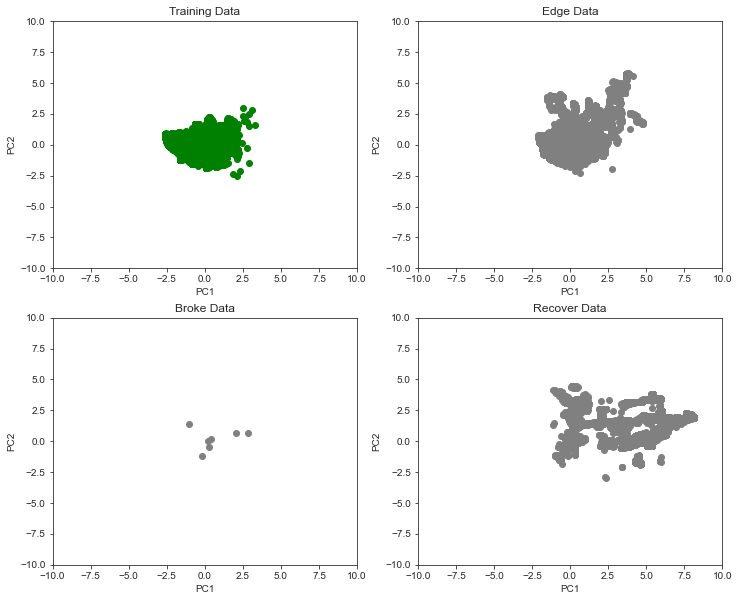

In [404]:
# Plot PC1 vs PC2 for training & test sets
fig, axes = plt.subplots(2, 2, figsize = (12, 10))
gs = gridspec.GridSpec(2, 2, width_ratios = [1, 1])

ax0 = plt.subplot(gs[0])
ax0.scatter(X_train_PCA.loc[:, 0], X_train_PCA.loc[:, 1], color = 'green')
ax0.set_xlabel('PC1')
ax0.set_ylabel('PC2')
ax0.set_xlim(-10, 10)
ax0.set_ylim(-10, 10)
ax0.set_title('Training Data')

ax1 = plt.subplot(gs[1])
ax1.scatter(X_test1_PCA.loc[:, 0], X_test1_PCA.loc[:, 1], color = 'grey')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_xlim(-10, 10)
ax1.set_ylim(-10, 10)
ax1.set_title('Edge Data')

ax2 = plt.subplot(gs[2])
ax2.scatter(X_test2_PCA.loc[:, 0], X_test2_PCA.loc[:, 1], color = 'grey')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_xlim(-10, 10)
ax2.set_ylim(-10, 10)
ax2.set_title('Broke Data')

ax3 = plt.subplot(gs[3])
ax3.scatter(X_test3_PCA.loc[:, 0], X_test3_PCA.loc[:, 1], color = 'grey')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_xlim(-10, 10)
ax3.set_ylim(-10, 10)
ax3.set_title('Recover Data')

plt.show()

The edge and recovery data are noticeably different than the training (normal data).  Edge data includes 1 day before and after the event/recovery.

In [405]:
# Move on to calculate Mahalanobis Distance 
# This is a multivatiate distance from centroid calculation that
# can be useful for unsupervised anomaly detection
data_train = np.array(X_train_PCA.values)
data_test1 = np.array(X_test1_PCA.values)
data_test2 = np.array(X_test2_PCA.values)
data_test3 = np.array(X_test3_PCA.values)

cov_matrix = np.cov(data_train, rowvar = False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Mean of each column: PC1, PC2 (it should be very close to zero)
mean_distr = data_train.mean(axis = 0) # axis=0 means that average is computed per column
np.set_printoptions(precision = 3, suppress = False)
print('Mean distr', mean_distr)

# Mahalanobis Distance calculation
dist_test1 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test1, verbose=False)
dist_test2 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test2, verbose=False)
dist_test3 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test3, verbose=False)
dist_train = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)

print("Minimum & maximum MD in training set:", min(dist_train), max(dist_train))
print("Minimum & maximum MD in test set 1  :", min(dist_test1), max(dist_test1))
print("Minimum & maximum MD in test set 2  :", min(dist_test2), max(dist_test2))
print("Minimum & maximum MD in test set 3  :", min(dist_test3), max(dist_test3))

threshold = pdm.MD_threshold(dist_train, extreme = True) # extreme = True; 2x mean of incoming data
print("Threshold value for flagging an anomaly is", "{:.2f}".format(threshold))

Mean distr [-5.240e-17  6.932e-17 -1.290e-17  2.317e-17]
Minimum & maximum MD in training set: 0.03418158063196248 7.882154400468786
Minimum & maximum MD in test set 1  : 0.18095818263546576 16.21813588339287
Minimum & maximum MD in test set 2  : 1.137611372015814 10.671521776637837
Minimum & maximum MD in test set 3  : 1.0317153993486776 17.569858349607763
Threshold value for flagging an anomaly is 5.59


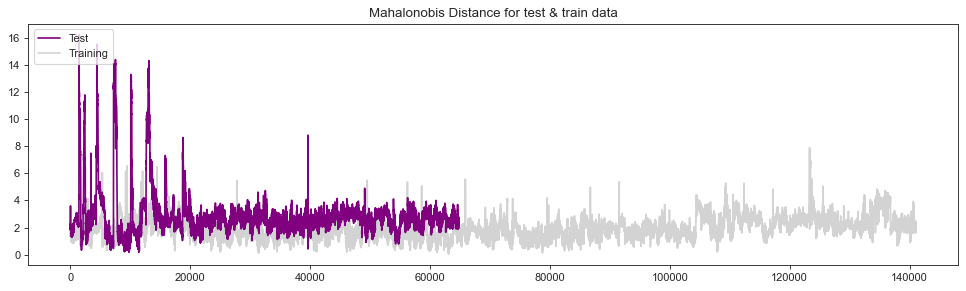

In [267]:
figure(figsize = (15, 4), dpi = 80)
plt.plot(np.array(dist_test1), label = "Test", color = 'purple', zorder = 2)
plt.plot(np.array(dist_train) , label = "Training", color = 'lightgrey', zorder = 1)
plt.legend(loc = "upper left")
plt.title("Mahalonobis Distance for test & train data")
plt.show()

/Users/jasonpayne/opt/anaconda3/envs/pdm/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


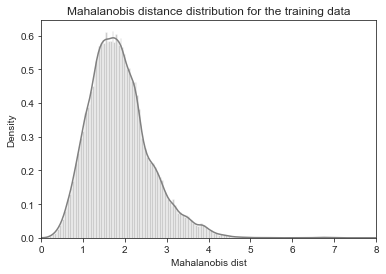

In [406]:
plt.figure()
sns.distplot(dist_train,
             bins = 200, 
             kde = True, 
            color = 'grey');
plt.xlim([0.0, 8])
plt.xlabel('Mahalanobis dist')
plt.title('Mahalanobis distance distribution for the training data')
plt.show()

In [407]:
def prep_mahalonobis_data (dist_dat, thresh, pca_dat):
    # Prepare test data for visualization
    dat = pd.DataFrame()
    dat['Mob dist'] = dist_dat
    dat['Thresh'] = thresh
    dat['Anomaly'] = dat['Mob dist'] > dat['Thresh']
    dat.index = pca_dat.index
    dat['timestamp'] = dat.index

    n_outliers = dat[dat['Anomaly'] == True].shape[0]
    print("There are", n_outliers, "anomalies in the test set out of", dat.shape[0], "points")
    print("Corresponding to " + str(round(100*(n_outliers / dat.shape[0]), 2)) + '%')

    return(dat)

In [408]:
# Prepare training data for visualization
# If Mahalonobis distance is above threshold: Flag as anomaly
anomaly_train = pdm.prep_mahalonobis_data(dist_train, threshold, X_train_PCA)
anomaly1 = pdm.prep_mahalonobis_data(dist_test1, threshold, X_test1_PCA)
anomaly2 = pdm.prep_mahalonobis_data(dist_test2, threshold, X_test2_PCA)
anomaly3 = pdm.prep_mahalonobis_data(dist_test3, threshold, X_test3_PCA)

There are 77 anomalies in the test set out of 141037 points
> Corresponding to 0.05%
There are 3038 anomalies in the test set out of 64799 points
> Corresponding to 4.69%
There are 2 anomalies in the test set out of 7 points
> Corresponding to 28.57%
There are 14400 anomalies in the test set out of 14477 points
> Corresponding to 99.47%


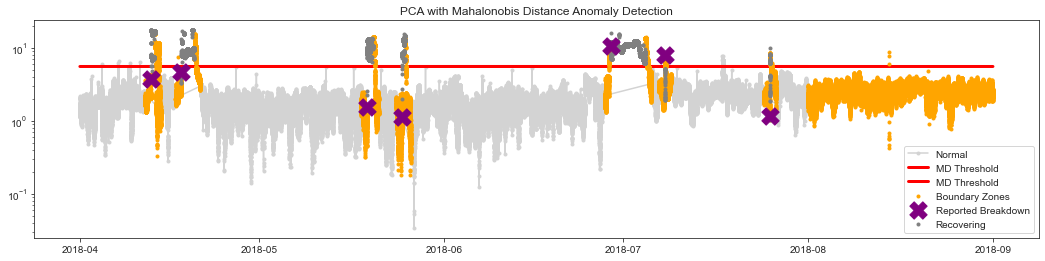

In [409]:
# Visualize Mahalonobis distance with actual anomalies vs threshold  
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(anomaly_train['timestamp'], anomaly_train['Mob dist'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Normal')
ax.plot(anomaly_train['timestamp'], anomaly_train['Thresh'], color = 'red', marker = None, linewidth = 3, zorder = 2, label = 'MD Threshold')
ax.plot(anomaly1['timestamp'], anomaly1['Thresh'], color = 'red', marker = None, linewidth = 3, zorder = 2, label = 'MD Threshold')
ax.scatter(anomaly1['timestamp'], anomaly1['Mob dist'], color = 'orange', marker = '.', zorder = 3, label = 'Boundary Zones')
ax.scatter(anomaly2['timestamp'], anomaly2['Mob dist'], color = 'purple', marker = 'X', zorder = 5, s = 300, label = 'Reported Breakdown')
ax.scatter(anomaly3['timestamp'], anomaly3['Mob dist'], color = 'grey', marker = '.', zorder = 4, label = 'Recovering')
ax.set_yscale('log')
plt.title('PCA with Mahalonobis Distance Anomaly Detection')
ax.legend(loc = 'lower right')
plt.show()

Not particularly good performance at detecting the breakdown events.  5 & 6 are detected but the others are missed.  The section of 'normal' added to the test data is show in orange on the right hand side of the plot.  This unseen normal section is correctly classified as normal (with the exception of one local splike).  Zoom in now on each breakdown zone and inspection the transition zones more closely. 

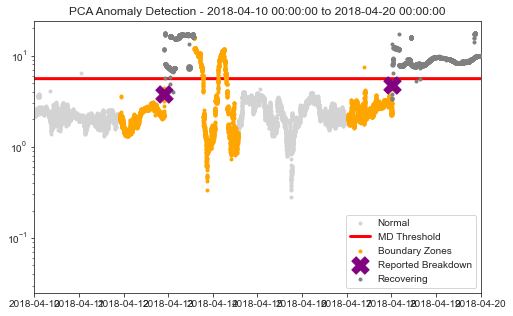

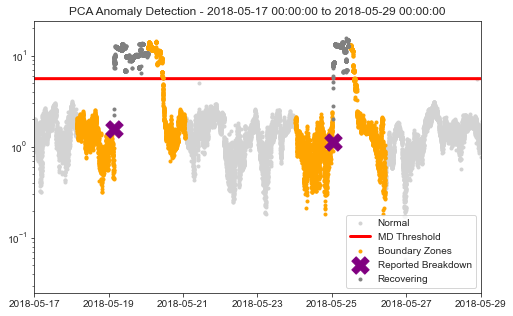

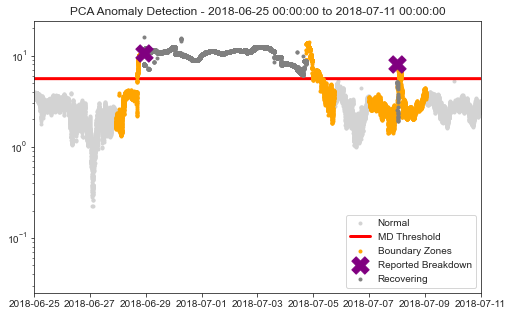

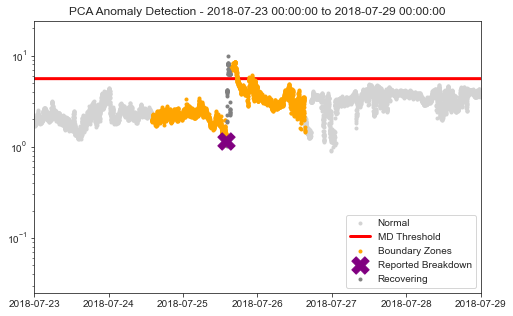

In [410]:
"""
Visualize Mahalonobis distance with actual anomalies vs threshold 
Zoom in on each breakdown period & examine distance in lead up to 
the reporting of the machine as 'broken'
""" 
start_slice = [ # Start times for zoomed views
    pd.to_datetime('2018-04-10 00:00:00', format = '%Y-%m-%d %H:%M:%S'), 
    pd.to_datetime('2018-05-17 00:00:00', format = '%Y-%m-%d %H:%M:%S'), 
    pd.to_datetime('2018-06-25 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-07-23 00:00:00', format = '%Y-%m-%d %H:%M:%S')
]
ender_slice = [ # End times for zoomed views
    pd.to_datetime('2018-04-20 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-05-29 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-07-11 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-07-29 00:00:00', format = '%Y-%m-%d %H:%M:%S')
]
# Loop through and plot each zoomed view
for i in range(4):
    fig, ax = plt.subplots(figsize = (8, 5))
    ax.scatter(anomaly_train['timestamp'], anomaly_train['Mob dist'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Normal')
    ax.plot(anomaly_train['timestamp'], anomaly_train['Thresh'], color = 'red', marker = None, linewidth=3, zorder = 2, label = 'MD Threshold')
    ax.scatter(anomaly1['timestamp'], anomaly1['Mob dist'], color = 'orange', marker = '.', zorder = 3, label = 'Boundary Zones')
    ax.scatter(anomaly2['timestamp'], anomaly2['Mob dist'], color = 'purple', marker = 'X', zorder = 5, s = 300, label = 'Reported Breakdown')
    ax.scatter(anomaly3['timestamp'], anomaly3['Mob dist'], color = 'grey', marker = '.', zorder = 4, label = 'Recovering')
    ax.set_yscale('log')
    ax.set_xlim(start_slice[i], ender_slice[i]),
    plt.title(f'PCA Anomaly Detection - {start_slice[i]} to {ender_slice[i]}')
    ax.legend(loc = 'lower right')
    plt.show()

Note: It is possible that the labels for breakdown are not accurately applied in the dataset. 

### MODEL 2. Clustering & Euclidean Distance
Try a K-means clustering approach where we group together usual combinations of features. The points that are far from the cluster are points with an unusual combination of features and these points will be classified as anomalies.

In [275]:
from sklearn.cluster import KMeans

In [412]:
include_num_cols = [
    'sensor_00', 
    'sensor_01', 
    'sensor_02', 
    'sensor_03', 
    'sensor_04', 
    'sensor_05', 
    'sensor_06', 
    'sensor_10' 
]

# Standardize the features
scaler1 = preprocessing.StandardScaler()
np_scaled = scaler1.fit_transform(df_set.loc[:, include_num_cols])
data_km = pd.DataFrame(np_scaled)

# Reduce to 2 PCA features
pca = PCA(n_components=2)
data = pca.fit_transform(data_km)

# Standardize these 2 new features
scaler2 = preprocessing.StandardScaler()
np_scaled = scaler2.fit_transform(data)
data = pd.DataFrame(np_scaled, columns = ['PC1', 'PC2'])

In [413]:
#df_set.loc[:, include_num_cols] 

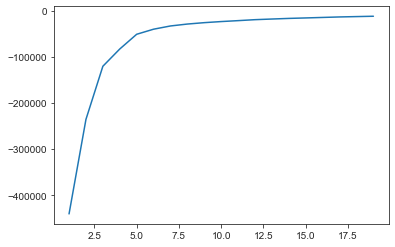

In [414]:
# Calculate with different numbers of centroids & plot the loss (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i, random_state=1234).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [415]:
# Choose 15 centroids & add these data to the base dataframe
#kmeans_model = KMeans(n_clusters=15, random_state=1234).fit(data)
if 'df' in globals(): del df
df = df_set.copy(deep=True)
df['cluster'] = kmeans[14].predict(data)
df.reset_index(drop = True, inplace = True)
df['principal_feature1'] = pd.Series(data['PC1'])
df['principal_feature2'] = pd.Series(data['PC2'])
df['cluster'].value_counts()

10    37077
4     33440
14    32620
2     30237
0     22431
13    20170
7     13914
9     12267
1      4583
5      3832
3      3336
6      1952
12     1775
8      1542
11     1144
Name: cluster, dtype: int64

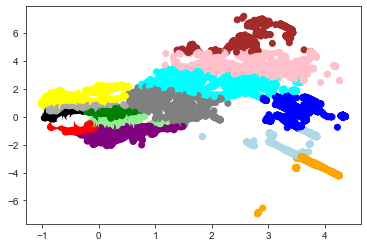

In [416]:
# Plot the different clusters with the 2x PCA component features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [417]:
"""
Create a function that returns a list of distances 
between each point & its distance to the closest centroid
Use 'np.linalg.norm' as the Euclidean distance is the l2 norm, 
and the default value of the ord parameter in numpy.linalg.norm is 2.
"""
def getDistanceByPoint(dat, model):
    distance = []
    for i in range(0, len(dat)):
        Xa = np.array(dat.loc[i])
        Xb = model.cluster_centers_[model.labels_[i] - 1]
        distance.append(np.linalg.norm(Xa - Xb))
    return distance

In [418]:
# Get the distance between each point and its nearest centroid. 
# The biggest distances will be considered as anomalies (using outlier_fraction assumption)
distance = pd.Series(getDistanceByPoint(data, kmeans[14]))

/Users/jasonpayne/opt/anaconda3/envs/pdm/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


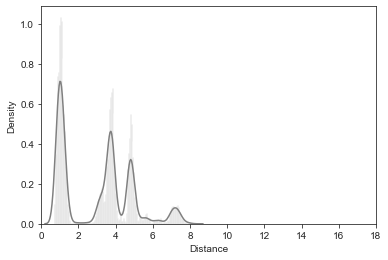

In [419]:
plt.figure()
sns.distplot(distance, bins = 200, kde = True, color = 'grey');
plt.xlim([0.0, 18])
plt.xlabel('Distance')
plt.show()

In [420]:
outliers_fraction = 0.1
number_of_outliers = int(outliers_fraction * len(distance))
threshold = distance.nlargest(number_of_outliers).min()

# Prediction will contain the anomaly result (0:normal, 1:anomaly) 
df['prediction'] = (distance >= threshold).astype(int)

In [421]:
print(f'Selected anomaly percentage: {100 * outliers_fraction}%')
print('Selected threshold distance:', round(threshold, 3))

Selected anomaly percentage: 10.0%
Selected threshold distance: 5.011


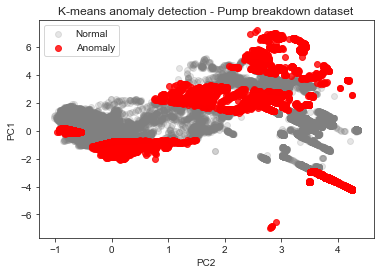

In [424]:
# Visualisation of anomaly with cluster view
fig, ax = plt.subplots()

# Now plot
ax.scatter(df[df.prediction == 0].principal_feature1, df[df.prediction == 0].principal_feature2, 
           zorder = 1, alpha = 0.2, c = 'grey', label = 'Normal')
ax.scatter(df[df.prediction == 1].principal_feature1, df[df.prediction == 1].principal_feature2, 
           zorder = 2, alpha = 0.8, c = 'red', label = 'Anomaly')
plt.ylabel("PC1")
plt.xlabel("PC2")
plt.title('K-means anomaly detection - Pump breakdown dataset')
ax.legend(loc = 'upper left')  
plt.show()

In [425]:
df.index = df.timestamp

In [426]:
res_snap_cl = df.loc[df.index.isin(df_train.index),:]
# Check false positive rate (from the training data)
# This should cross check with contamination rate specified in SVM model (~0.5%)
cl_to = len(res_snap_cl['prediction'])
cl_fp = sum(res_snap_cl['prediction'] == 1)
cl_tn = sum(res_snap_cl['prediction'] == 0)
print(f'False positives in training set {cl_fp} ({round(100*cl_fp/cl_to, 2)}%)')
print(f'Check {"{:,}".format(cl_to)} (total rows) = {"{:,}".format(cl_fp+cl_tn)} (FP + TN count): {cl_to == (cl_fp+cl_tn)}')

False positives in training set 8305 (5.89%)
Check 141,037 (total rows) = 141,037 (FP + TN count): True


In [427]:
def calc_anomaly_perf(snapshot):
    cl_to = len(snapshot['prediction'])
    cl_an = sum(snapshot['prediction'] == 1)
    cl_nn = sum(snapshot['prediction'] == 0)
    print(f'Anomaly point count is {cl_an} ({round(100*cl_an/cl_to, 2)}%)')
    print(f'Check {"{:,}".format(cl_to)} (total rows) = {"{:,}".format(cl_an+cl_nn)} (FP + TN count): {cl_to == (cl_an+cl_nn)}')

In [431]:
calc_anomaly_perf(df.loc[df.index.isin(df_test1.index),:])

Anomaly point count is 7600 (11.73%)
Check 64,799 (total rows) = 64,799 (FP + TN count): True


In [432]:
calc_anomaly_perf(df.loc[df.index.isin(df_test2.index),:])

Anomaly point count is 2 (28.57%)
Check 7 (total rows) = 7 (FP + TN count): True


This appears to be poor performance, lets investigate further.  Firstly, lets remind ourselves of the breakdown times.

In [433]:
df.loc[df.machine_status == 'BROKEN']

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status,cluster,principal_feature1,principal_feature2,prediction
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-12 21:55:00,2018-04-12 21:55:00,0.000000,53.342010,52.821180,43.402775,202.526031,49.79289,13.62847,16.890910,16.869210,...,51.215280,50.636570,46.006940,409.143500,121.527800,BROKEN,6,1.104781,2.193007,1
2018-04-18 00:30:00,2018-04-18 00:30:00,1.093982,42.534720,47.699650,41.449650,206.038757,60.30106,12.30469,15.154800,14.185470,...,31.539350,34.432870,33.275460,59.895830,44.560180,BROKEN,11,1.800587,0.536851,0
2018-05-19 03:18:00,2018-05-19 03:18:00,2.258796,47.265630,52.734370,43.446178,200.115738,66.14643,13.59230,15.914350,15.147570,...,37.905090,39.062500,45.428240,144.675900,49.768520,BROKEN,2,0.471297,0.431769,0
2018-05-25 00:30:00,2018-05-25 00:30:00,2.321759,47.482640,51.475693,42.795135,612.152800,67.30158,14.06250,16.608800,15.943290,...,57.870370,127.893500,153.935200,155.381900,65.682870,BROKEN,2,0.214563,0.131834,0
2018-06-28 22:00:00,2018-06-28 22:00:00,0.364005,40.190970,45.225690,40.190971,201.368622,0.00000,11.33536,15.270540,15.183740,...,28.067129,29.513889,29.224537,29.224537,29.513889,BROKEN,3,3.119807,2.881968,0
2018-07-08 00:11:00,2018-07-08 00:11:00,0.001968,45.138890,52.907990,45.355900,500.000000,1.40131,13.62847,0.036169,0.036169,...,35.300930,38.194440,43.402780,99.537030,44.849540,BROKEN,6,1.342712,3.266729,1
2018-07-25 14:00:00,2018-07-25 14:00:00,2.318808,45.833332,52.994790,43.880210,420.503448,72.52040,14.18547,16.247110,15.697340,...,52.662040,67.129630,43.981480,230.324100,69.733800,BROKEN,2,0.214821,-0.100357,0


Let's inspect the actual windows to see if it came closeto detecting other breakdown events. 

In [434]:
# Let's investigate breakdown 1
df[(df.index >= '2018-04-12 21:54:00') & (df.index < '2018-04-12 22:00:00')].prediction

timestamp
2018-04-12 21:54:00    1
2018-04-12 21:55:00    1
2018-04-12 21:56:00    0
2018-04-12 21:57:00    0
2018-04-12 21:58:00    0
2018-04-12 21:59:00    0
Name: prediction, dtype: int64

FOUND: Breakdown 1 is found.

In [439]:
# Let's investigate breakdown 2
df[(df.index >= '2018-04-18 00:28:00') & (df.index < '2018-04-18 00:35:00')].prediction

timestamp
2018-04-18 00:28:00    0
2018-04-18 00:29:00    0
2018-04-18 00:30:00    0
2018-04-18 00:31:00    0
2018-04-18 00:32:00    0
2018-04-18 00:33:00    0
2018-04-18 00:34:00    0
Name: prediction, dtype: int64

Breakdown 2 is missed.

In [440]:
# Let's investigate breakdown 3
df[(df.index >= '2018-05-19 03:16:00') & (df.index < '2018-05-19 03:24:00')].prediction

timestamp
2018-05-19 03:16:00    0
2018-05-19 03:17:00    0
2018-05-19 03:18:00    0
2018-05-19 03:19:00    0
2018-05-19 03:20:00    0
2018-05-19 03:21:00    1
2018-05-19 03:22:00    1
2018-05-19 03:23:00    1
Name: prediction, dtype: int64

Breakdown 3 is missed by two timesteps.

In [441]:
# Let's investigate breakdown 4
df[(df.index >= '2018-05-25 00:28:00') & (df.index < '2018-05-25 00:35:00')].prediction

timestamp
2018-05-25 00:28:00    0
2018-05-25 00:29:00    0
2018-05-25 00:30:00    0
2018-05-25 00:31:00    0
2018-05-25 00:32:00    0
2018-05-25 00:33:00    0
2018-05-25 00:34:00    0
Name: prediction, dtype: int64

Breakdown 4 is missed.

In [437]:
# Let's investigate breakdown 5
df[(df.index >= '2018-06-28 22:00:00') & (df.index < '2018-06-28 22:10:00')].prediction

timestamp
2018-06-28 22:00:00    0
2018-06-28 22:01:00    0
2018-06-28 22:02:00    1
2018-06-28 22:03:00    1
2018-06-28 22:04:00    1
2018-06-28 22:05:00    1
2018-06-28 22:06:00    1
2018-06-28 22:07:00    1
2018-06-28 22:08:00    1
2018-06-28 22:09:00    1
Name: prediction, dtype: int64

Breakdown 5 is missed by two timesteps.

In [300]:
# Let's investigate breakdown 6
df[(df.index >= '2018-07-08 00:11:00') & (df.index < '2018-07-09 00:11:00')].prediction

timestamp
2018-07-08 00:11:00    1
2018-07-08 00:12:00    0
2018-07-08 00:13:00    0
2018-07-08 00:14:00    0
2018-07-08 00:15:00    0
                      ..
2018-07-09 00:06:00    0
2018-07-09 00:07:00    0
2018-07-09 00:08:00    0
2018-07-09 00:09:00    0
2018-07-09 00:10:00    0
Name: prediction, Length: 1440, dtype: int64

FOUND: Breakdown 6 is found.

In [438]:
# Let's verify detection for breakdown 7
df[(df.index >= '2018-07-25 14:00:00') & (df.index < '2018-07-25 14:05:00')].prediction

timestamp
2018-07-25 14:00:00    0
2018-07-25 14:01:00    0
2018-07-25 14:02:00    0
2018-07-25 14:03:00    0
2018-07-25 14:04:00    0
Name: prediction, dtype: int64

Breakdown 7 is missed.

In [480]:
calc_anomaly_perf(df.loc[df.index.isin(df_test3.index),:])

Anomaly point count is 6125 (42.31%)
Check 14,477 (total rows) = 14,477 (FP + TN count): True


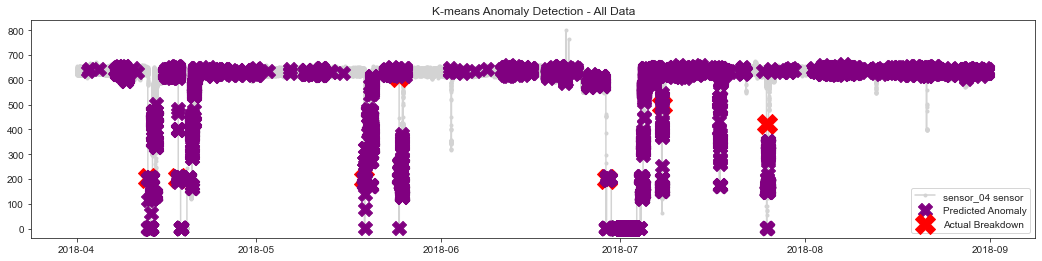

In [442]:
# Create visualisation of anomaly detection through time
fig, ax = plt.subplots(figsize = (18, 4))

# Revert the index to the datetime
df.index = df_set.index

# Create a subset dataset of anomalies
a = df.loc[df['prediction'] == 1, [backdrop_chan]] # anomaly using sensor as backdrop
b = df.loc[df['machine_status'] == 'BROKEN', [backdrop_chan]] # anomaly using sensor as backdrop

ax.plot(df.index, df[backdrop_chan], color='lightgrey', marker = '.', zorder=2, label = f'{backdrop_chan} sensor')
ax.scatter(a.index, a[backdrop_chan], color='purple', marker='X', s = 200, zorder=4, label = 'Predicted Anomaly')
ax.scatter(b.index, b[backdrop_chan], color='red', marker='X', s = 400, zorder=3, label = 'Actual Breakdown')
plt.title(f'K-means Anomaly Detection - All Data')
ax.legend(loc = 'lower right')  
plt.show()

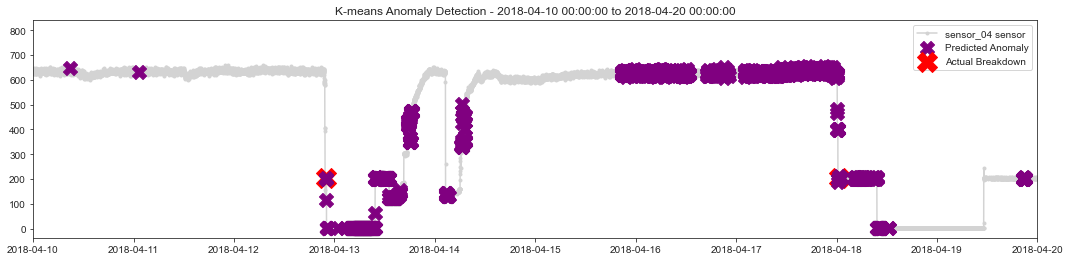

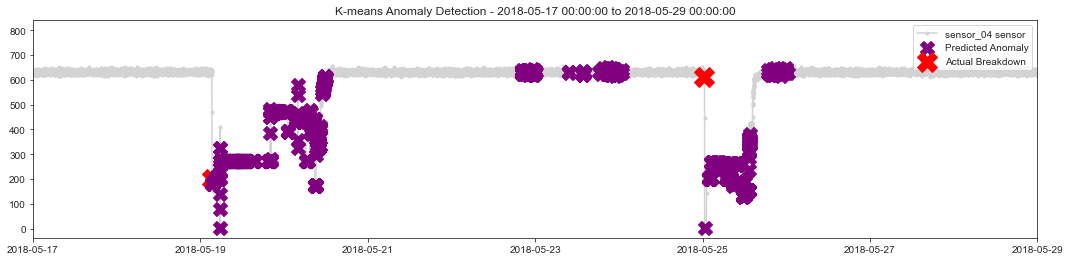

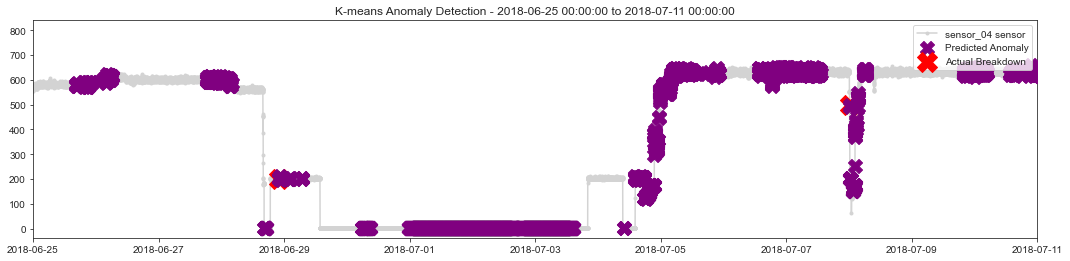

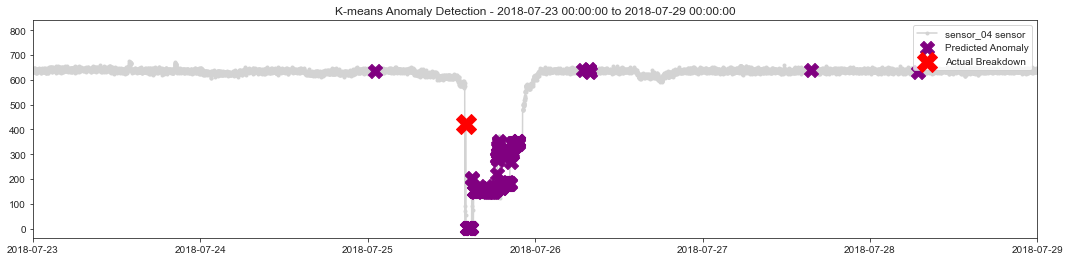

In [443]:
"""
Zoom in on each breakdown period & examine distance in lead up to 
the reporting of the machine as 'broken'
""" 
start_slice = [ # Start times for zoomed views
    pd.to_datetime('2018-04-10 00:00:00', format = '%Y-%m-%d %H:%M:%S'), 
    pd.to_datetime('2018-05-17 00:00:00', format = '%Y-%m-%d %H:%M:%S'), 
    pd.to_datetime('2018-06-25 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-07-23 00:00:00', format = '%Y-%m-%d %H:%M:%S')
]
ender_slice = [ # End times for zoomed views
    pd.to_datetime('2018-04-20 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-05-29 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-07-11 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-07-29 00:00:00', format = '%Y-%m-%d %H:%M:%S')
]
# Loop through and plot each zoomed view
for i in range(4):
    # Create visualisation of anomaly detection through time
    fig, ax = plt.subplots(figsize = (18, 4))
    df.index = df_set.index
    # Create a subset dataset of anomalies
    a = df.loc[df['prediction'] == 1, [backdrop_chan]] # anomaly using sensor as backdrop
    b = df.loc[df['machine_status'] == 'BROKEN', [backdrop_chan]] # anomaly using sensor as backdrop
    ax.plot(df.index, df[backdrop_chan], color='lightgrey', marker = '.', zorder=2, label = f'{backdrop_chan} sensor')
    ax.scatter(a.index, a[backdrop_chan], color='purple', marker='X', s = 200, zorder=4, label = 'Predicted Anomaly')
    ax.scatter(b.index, b[backdrop_chan], color='red', marker='X', s = 400, zorder=3, label = 'Actual Breakdown')
    ax.set_xlim(start_slice[i], ender_slice[i]),
    plt.title(f'K-means Anomaly Detection - {start_slice[i]} to {ender_slice[i]}')
    ax.legend(loc = 'upper right')
    plt.show()

To be added

### MODEL 3. One-class Support Vector Machine (SVM)
SVMs use hyperplanes in multi-dimensional space to separate one class of observations from another. In a one-class SVM problem, all data belongs to a single class (often the normal class). The model is trained to learn these 'normal' conditions, so that when a new data is encountered, it can identify whether it should belong to trained class or not. If not, the new data is labeled as an anomaly.

In [444]:
from sklearn.svm import OneClassSVM

In [445]:
# Prepare data for dimensional reduction
df_train = df_norm.loc[:, include_cols]  
df_train = df_train.drop(['machine_status', 'timestamp'], axis = 1)                      

df_test1 = df_abnorm_lead.loc[:, include_cols]
df_test1 = df_test1.drop(['machine_status', 'timestamp'], axis = 1)  

df_test2 = df_abnorm_broke.loc[:, include_cols]
df_test2 = df_test2.drop(['machine_status', 'timestamp'], axis = 1)  

df_test3 = df_abnorm_recover.loc[:, include_cols]
df_test3 = df_test3.drop(['machine_status', 'timestamp'], axis = 1)

In [446]:
# Train a one-class SVM 
# nu = contamination 
svm_model =  OneClassSVM(nu = 0.01) # 1%
svm_model.fit(pd.DataFrame(df_train))

OneClassSVM(nu=0.01)

In [447]:
# Predict for train set (normal operating)
preds = pd.Series(svm_model.predict(df_train))
test = pd.DataFrame({'sensor_04':pd.Series(df_train['sensor_04'])})
svm_out = pd.DataFrame({'timestamp':df_train.index, 'Prediction':preds})
sensor_04 = df_train['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
svm_out['sensor_04'] = sensor_04
svm_out['Prediction'] = svm_out['Prediction'].map({1: 0, -1: 1})
svm_aly = svm_out.loc[svm_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(svm_aly)) + ' out of ' + str(len(svm_out)) + ' (' + str(round(100 * (len(svm_aly) / len(svm_out)), 2)) + '%)')
svm_aly0 = svm_aly

1859 out of 185676 (1.0%)


In [448]:
chk_preds = pd.Series(svm_model.predict(df_train)).map({1: 0, -1: 1})
print('Cross check anomaly count: ', sum((chk_preds == 1).astype(int)))

Cross check anomaly count:  1859


In [449]:
# Predict for test set 1 (boundary segments)
preds = pd.Series(svm_model.predict(df_test1))
test = pd.DataFrame({'sensor_04':pd.Series(df_test1['sensor_04'])})
svm_out = pd.DataFrame({'timestamp':df_test1.index, 'Prediction':preds})
sensor_04 = df_test1['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
svm_out['sensor_04'] = sensor_04
svm_out['Prediction'] = svm_out['Prediction'].map({1: 0, -1: 1})
svm_aly = svm_out.loc[svm_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(svm_aly)) + ' out of ' + str(len(svm_out)) + ' (' + str(round(100 * (len(svm_aly) / len(svm_out)), 2)) + '%)')
svm_aly1 = svm_aly

6873 out of 20160 (34.09%)


In [450]:
# Predict for test set 2 (breakdown points)
preds = pd.Series(svm_model.predict(df_test2))
test = pd.DataFrame({'sensor_04':pd.Series(df_test2['sensor_04'])})
svm_out = pd.DataFrame({'timestamp':df_test2.index, 'Prediction':preds})
sensor_04 = df_test2['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
svm_out['sensor_04'] = sensor_04
svm_out['Prediction'] = svm_out['Prediction'].map({1: 0, -1: 1})
svm_aly = svm_out.loc[svm_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(svm_aly)) + ' out of ' + str(len(svm_out)) + ' (' + str(round(100 * (len(svm_aly) / len(svm_out)), 2)) + '%)')
svm_aly2 = svm_aly

7 out of 7 (100.0%)


FOUND: 7 of 7 breakdown events correctly labelled as anomalies.

In [451]:
# Predict for test set 3 (recovery points)
preds = pd.Series(svm_model.predict(df_test3))
test = pd.DataFrame({'sensor_04':pd.Series(df_test3['sensor_04'])})
svm_out = pd.DataFrame({'timestamp':df_test3.index, 'Prediction':preds})
sensor_04 = df_test3['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
svm_out['sensor_04'] = sensor_04
svm_out['Prediction'] = svm_out['Prediction'].map({1: 0, -1: 1})
svm_aly = svm_out.loc[svm_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(svm_aly)) + ' out of ' + str(len(svm_out)) + ' (' + str(round(100 * (len(svm_aly) / len(svm_out)), 2)) + '%)')
svm_aly3 = svm_aly

14477 out of 14477 (100.0%)


100% of data in recovery zones correctly classified as anomalies.

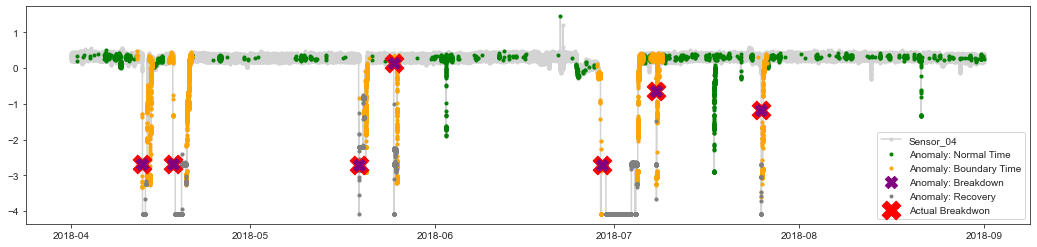

In [479]:
# Visualize machine status over time for the data using sensor04 as reference
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(df_set['timestamp'], df_set_scaled['sensor_04'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Sensor_04')
ax.scatter(svm_aly0['timestamp'], svm_aly0['sensor_04'], color ='green', marker = '.', zorder = 2, label = 'Anomaly: Normal Time')
ax.scatter(svm_aly1['timestamp'], svm_aly1['sensor_04'], color ='orange', marker = '.', zorder = 2, label = 'Anomaly: Boundary Time')
ax.scatter(svm_aly2['timestamp'], svm_aly2['sensor_04'], color ='purple', marker = 'X', s = 150, zorder = 5, label = 'Anomaly: Breakdown')
ax.scatter(svm_aly3['timestamp'], svm_aly3['sensor_04'], color ='grey', marker = '.', zorder = 3, label = 'Anomaly: Recovery')
ax.scatter(df_abnorm_broke['timestamp'], df_abnorm_broke['sensor_04'], color = 'red', marker = 'X', zorder = 4, s = 350, label = 'Actual Breakdwon')
ax.legend(loc = 'lower right')
plt.show()

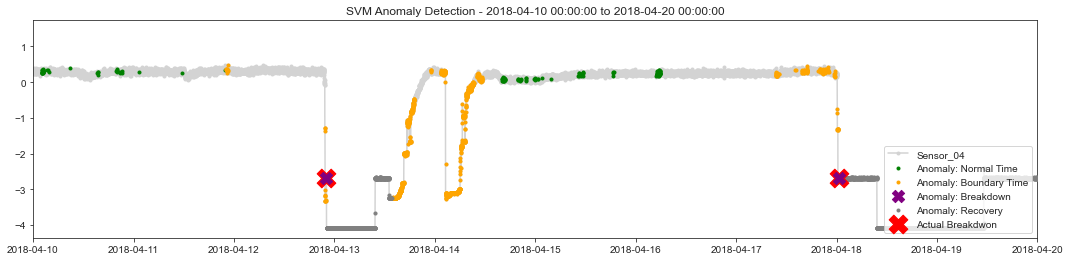

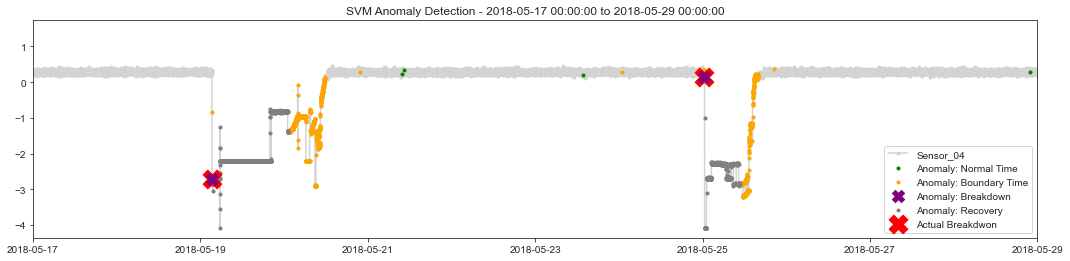

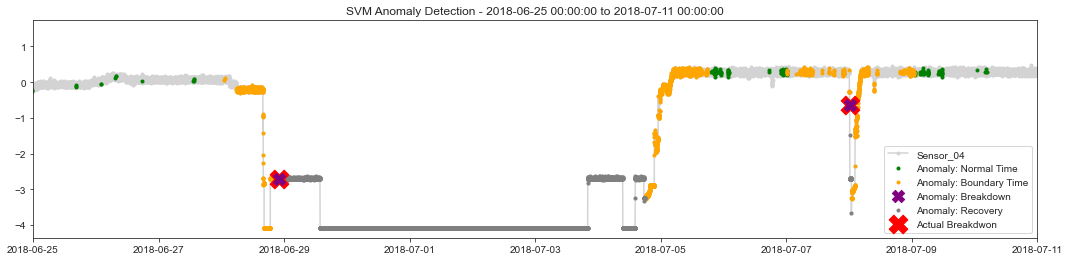

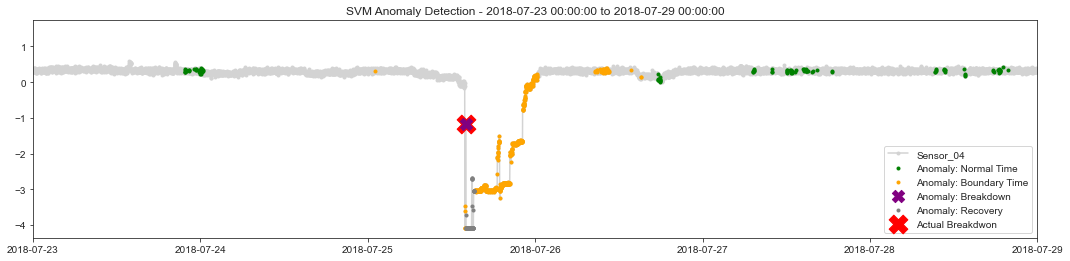

In [453]:
"""
Zoom in on each breakdown period & examine distance in lead up to 
the reporting of the machine as 'broken'
""" 
start_slice = [ # Start times for zoomed views
    pd.to_datetime('2018-04-10 00:00:00', format = '%Y-%m-%d %H:%M:%S'), 
    pd.to_datetime('2018-05-17 00:00:00', format = '%Y-%m-%d %H:%M:%S'), 
    pd.to_datetime('2018-06-25 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-07-23 00:00:00', format = '%Y-%m-%d %H:%M:%S')
]
ender_slice = [ # End times for zoomed views
    pd.to_datetime('2018-04-20 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-05-29 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-07-11 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-07-29 00:00:00', format = '%Y-%m-%d %H:%M:%S')
]
# Loop through and plot each zoomed view
for i in range(4):
    fig, ax = plt.subplots(figsize = (18, 4))
    ax.plot(df_set['timestamp'], df_set_scaled['sensor_04'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Sensor_04')
    ax.scatter(svm_aly0['timestamp'], svm_aly0['sensor_04'], color ='green', marker = '.', zorder = 2, label = 'Anomaly: Normal Time')
    ax.scatter(svm_aly1['timestamp'], svm_aly1['sensor_04'], color ='orange', marker = '.', zorder = 2, label = 'Anomaly: Boundary Time')
    ax.scatter(svm_aly2['timestamp'], svm_aly2['sensor_04'], color ='purple', marker = 'X', s = 150, zorder = 5, label = 'Anomaly: Breakdown')
    ax.scatter(svm_aly3['timestamp'], svm_aly3['sensor_04'], color ='grey', marker = '.', zorder = 3, label = 'Anomaly: Recovery')
    ax.scatter(df_abnorm_broke['timestamp'], df_abnorm_broke['sensor_04'], color = 'red', marker = 'X', zorder = 4, s = 350, label = 'Actual Breakdwon')
    ax.legend(loc = 'lower right')
    ax.set_xlim(start_slice[i], ender_slice[i]),
    plt.title(f'SVM Anomaly Detection - {start_slice[i]} to {ender_slice[i]}')
    plt.show()

### MODEL 4. Isolation Forest

Overview of Isolation forest steps:
https://ieeexplore.ieee.org/abstract/document/4781136

An Isolation Forest is a tree-based unsupervised model.  In an Isolation Forest, randomly sub-sampled data are processed in a tree structure based on randomly selected features. Samples that travel deeper into the tree are less likely to be anomalies as they required more cuts to isolate them. Similarly, the samples which end up in shorter branches indicate anomalies as it was easier for the tree to separate them from other observations.
1. Build trees,
2. Pass each data point through each tree,
3. Calculate the average path that is required to isolate the point.
4. The shorter the path, the higher the anomaly score.

In [454]:
from sklearn.ensemble import IsolationForest

In [455]:
# Prepare data for dimensional reduction
df_train = df_norm.loc[:, include_cols]  
df_train = df_train.drop(['machine_status', 'timestamp'], axis = 1)                      

df_test1 = df_abnorm_lead.loc[:, include_cols]
df_test1 = df_test1.drop(['machine_status', 'timestamp'], axis = 1)  

df_test2 = df_abnorm_broke.loc[:, include_cols]
df_test2 = df_test2.drop(['machine_status', 'timestamp'], axis = 1)  

df_test3 = df_abnorm_recover.loc[:, include_cols]
df_test3 = df_test3.drop(['machine_status', 'timestamp'], axis = 1)

In [456]:
# Train isolation forest 
isfo_model =  IsolationForest(contamination = 0.01) # 1%
isfo_model.fit(df_train)

IsolationForest(contamination=0.01)

In [457]:
# Predict for train set (normal operating)
preds = pd.Series(isfo_model.predict(df_train))
test = pd.DataFrame({'sensor_04':pd.Series(df_train['sensor_04'])})
isfo_out = pd.DataFrame({'timestamp':df_train.index, 'Prediction':preds})
sensor_04 = df_train['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
isfo_out['sensor_04'] = sensor_04
isfo_out['Prediction'] = isfo_out['Prediction'].map({1: 0, -1: 1})
isfo_aly = isfo_out.loc[isfo_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(isfo_aly)) + ' out of ' + str(len(isfo_out)) + ' (' + str(round(100 * (len(isfo_aly) / len(isfo_out)), 2)) + '%)')
isfo_aly0 = isfo_aly

1857 out of 185676 (1.0%)


In [458]:
chk_preds = pd.Series(isfo_model.predict(df_train)).map({1: 0, -1: 1})
print('Cross check anomaly count: ', sum((chk_preds == 1).astype(int)))

Cross check anomaly count:  1857


In [459]:
# Predict for test set 1 ()
preds = pd.Series(isfo_model.predict(df_test1))
test = pd.DataFrame({'sensor_04':pd.Series(df_test1['sensor_04'])})
isfo_out = pd.DataFrame({'timestamp':df_test1.index, 'Prediction':preds})
sensor_04 = df_test1['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
isfo_out['sensor_04'] = sensor_04
isfo_out['Prediction'] = isfo_out['Prediction'].map({1: 0, -1: 1})
isfo_aly = isfo_out.loc[isfo_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(isfo_aly)) + ' out of ' + str(len(isfo_out)) + ' (' + str(round(100 * (len(isfo_aly) / len(isfo_out)), 2)) + '%)')
isfo_aly1 = isfo_aly

4796 out of 20160 (23.79%)


In [460]:
# Predict for test set 2 ()
preds = pd.Series(isfo_model.predict(df_test2))
test = pd.DataFrame({'sensor_04':pd.Series(df_test2['sensor_04'])})
isfo_out = pd.DataFrame({'timestamp':df_test2.index, 'Prediction':preds})
sensor_04 = df_test2['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
isfo_out['sensor_04'] = sensor_04
isfo_out['Prediction'] = isfo_out['Prediction'].map({1: 0, -1: 1})
isfo_aly = isfo_out.loc[isfo_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(isfo_aly)) + ' out of ' + str(len(isfo_out)) + ' (' + str(round(100 * (len(isfo_aly) / len(isfo_out)), 2)) + '%)')
isfo_aly2 = isfo_aly

4 out of 7 (57.14%)


FOUND: 4 of 7 breakdown events classifed as anomalies.

In [461]:
# Predict for test set 3 ()
preds = pd.Series(isfo_model.predict(df_test3))
test = pd.DataFrame({'sensor_04':pd.Series(df_test3['sensor_04'])})
isfo_out = pd.DataFrame({'timestamp':df_test3.index, 'Prediction':preds})
sensor_04 = df_test3['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
isfo_out['sensor_04'] = sensor_04
isfo_out['Prediction'] = isfo_out['Prediction'].map({1: 0, -1: 1})
isfo_aly = isfo_out.loc[isfo_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(isfo_aly)) + ' out of ' + str(len(isfo_out)) + ' (' + str(round(100 * (len(isfo_aly) / len(isfo_out)), 2)) + '%)')
isfo_aly3 = isfo_aly

14470 out of 14477 (99.95%)


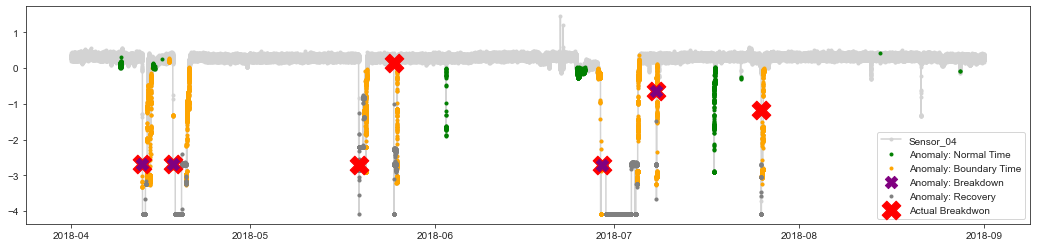

In [462]:
# Visualize machine status over time for the data using sensor04 as reference
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(df_set['timestamp'], df_set_scaled['sensor_04'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Sensor_04')
ax.scatter(isfo_aly0['timestamp'], isfo_aly0['sensor_04'], color ='green', marker = '.', zorder = 3, label = 'Anomaly: Normal Time')
ax.scatter(isfo_aly1['timestamp'], isfo_aly1['sensor_04'], color ='orange', marker = '.', zorder = 2, label = 'Anomaly: Boundary Time')
ax.scatter(isfo_aly2['timestamp'], isfo_aly2['sensor_04'], color ='purple', marker = 'X', s = 150, zorder = 6, label = 'Anomaly: Breakdown')
ax.scatter(isfo_aly3['timestamp'], isfo_aly3['sensor_04'], color ='grey', marker = '.', zorder = 4, label = 'Anomaly: Recovery')
ax.scatter(df_abnorm_broke['timestamp'], df_abnorm_broke['sensor_04'], color = 'red', marker = 'X', zorder = 5, s = 350, label = 'Actual Breakdwon')
ax.legend(loc = 'lower right')
plt.show()

Distribution of false positives is very different to the SVM, let's investigate/check this.  Row counts are double checked in the above code so these are OK, it is just the distributions that are different.  Check if this is a spacing difference, i.e., SVM FPs are more spaced than the IF which could be more clustered.

In [490]:
# Check time diffs for isolation forest
chk_isfo_diffs = isfo_aly0.copy(deep=True).timestamp.diff()[1:]
chk_isfo_diffs.reset_index(drop = True, inplace = True)
print('No. of unique gaps between anomalies for isolation forest ', len(chk_isfo_diffs.astype(str).unique()))

# Calculate run length encoding for the isolation forest timestamp diff column
rle_isfo = [(k, sum(1 for i in g)) for k, g in groupby(chk_isfo_diffs.astype(str))]
print('No. of runs: ', len(rle_isfo))
rle_isfo

No. of unique gaps between anomalies for isolation forest  37
No. of runs:  352


[('0 days 00:02:00', 2),
 ('0 days 00:03:00', 1),
 ('0 days 00:01:00', 174),
 ('0 days 00:02:00', 1),
 ('0 days 00:01:00', 5),
 ('0 days 00:16:00', 1),
 ('0 days 00:06:00', 1),
 ('0 days 00:03:00', 1),
 ('0 days 00:15:00', 1),
 ('0 days 00:01:00', 1),
 ('5 days 08:07:00', 1),
 ('0 days 00:01:00', 1),
 ('0 days 00:02:00', 1),
 ('0 days 00:01:00', 1),
 ('0 days 00:02:00', 1),
 ('0 days 00:01:00', 8),
 ('0 days 00:08:00', 1),
 ('0 days 00:01:00', 6),
 ('0 days 00:02:00', 1),
 ('0 days 00:01:00', 21),
 ('0 days 00:02:00', 3),
 ('0 days 00:01:00', 2),
 ('0 days 00:03:00', 1),
 ('0 days 00:02:00', 1),
 ('0 days 00:03:00', 1),
 ('0 days 01:50:00', 1),
 ('0 days 00:06:00', 1),
 ('0 days 00:15:00', 1),
 ('0 days 00:49:00', 1),
 ('0 days 00:10:00', 1),
 ('0 days 00:23:00', 1),
 ('0 days 00:04:00', 1),
 ('0 days 01:10:00', 1),
 ('0 days 01:59:00', 1),
 ('0 days 00:16:00', 1),
 ('0 days 00:01:00', 1),
 ('0 days 00:11:00', 1),
 ('1 days 05:32:00', 1),
 ('47 days 12:14:00', 1),
 ('0 days 00:01:00', 

In [491]:
# Check time diffs for SVM
chk_svm_diffs = svm_aly0.copy(deep=True).timestamp.diff()[1:]
chk_svm_diffs.reset_index(drop = True, inplace = True)
print('No. of unique gaps between anomalies for SVM ', len(chk_svm_diffs.astype(str).unique()))

# Calculate run length encoding for the SVM timestamp diff column
rle_svm = [(k, sum(1 for i in g)) for k, g in groupby(chk_svm_diffs.astype(str))]
print('No. of runs: ', len(rle_svm))
rle_svm

No. of unique gaps between anomalies for SVM  248
No. of runs:  829


[('0 days 00:21:00', 1),
 ('0 days 21:33:00', 1),
 ('0 days 03:57:00', 1),
 ('0 days 23:49:00', 1),
 ('0 days 00:01:00', 1),
 ('0 days 15:56:00', 1),
 ('0 days 16:37:00', 1),
 ('1 days 02:17:00', 1),
 ('0 days 00:07:00', 1),
 ('0 days 01:55:00', 1),
 ('0 days 00:51:00', 1),
 ('0 days 00:01:00', 4),
 ('0 days 00:03:00', 1),
 ('0 days 00:02:00', 1),
 ('0 days 01:49:00', 1),
 ('0 days 00:01:00', 1),
 ('0 days 00:03:00', 1),
 ('0 days 00:09:00', 1),
 ('0 days 00:02:00', 1),
 ('0 days 00:01:00', 7),
 ('0 days 00:02:00', 1),
 ('0 days 00:01:00', 23),
 ('0 days 00:04:00', 1),
 ('0 days 00:01:00', 2),
 ('0 days 00:09:00', 1),
 ('0 days 00:01:00', 2),
 ('0 days 00:02:00', 1),
 ('0 days 00:35:00', 1),
 ('0 days 00:02:00', 1),
 ('0 days 00:01:00', 2),
 ('0 days 00:39:00', 1),
 ('0 days 00:10:00', 1),
 ('0 days 00:01:00', 1),
 ('0 days 03:36:00', 1),
 ('0 days 00:25:00', 1),
 ('0 days 06:31:00', 1),
 ('0 days 00:01:00', 1),
 ('0 days 00:41:00', 1),
 ('0 days 00:02:00', 1),
 ('0 days 00:26:00', 1),

248 different time gaps for SVM compared to 37 for the isolation forest.  829 runs vs 352 (for isolation forest).

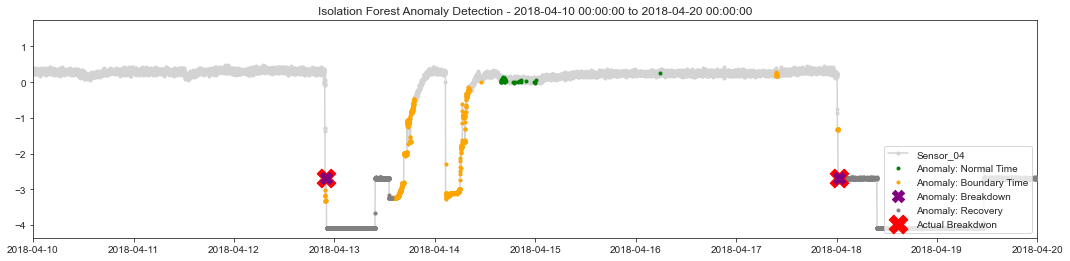

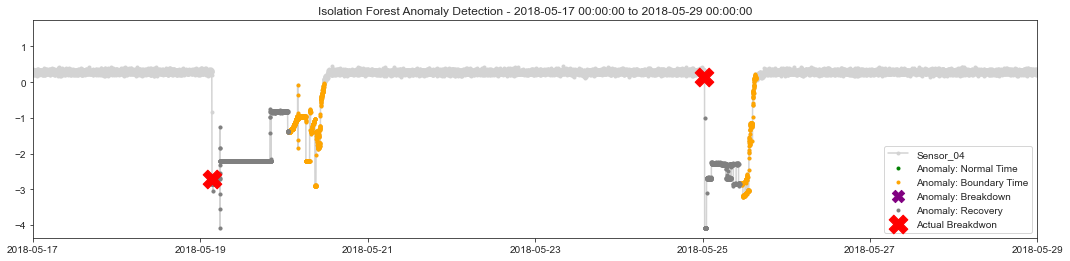

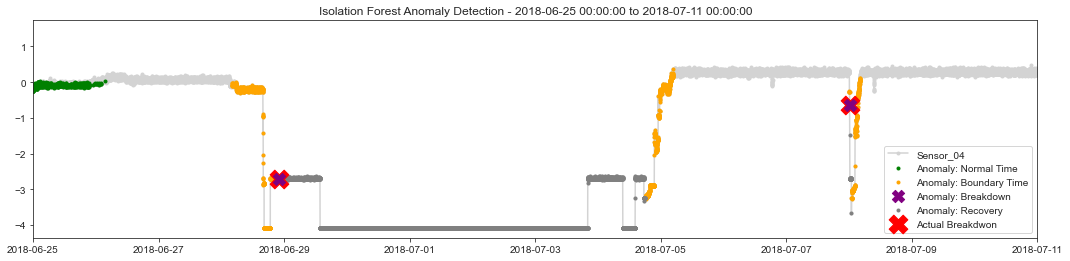

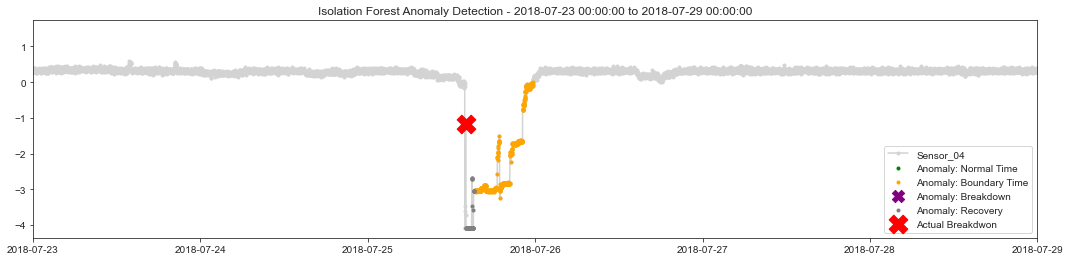

In [492]:
"""
Zoom in on each breakdown period & examine distance in lead up to 
the reporting of the machine as 'broken'
""" 
start_slice = [ # Start times for zoomed views
    pd.to_datetime('2018-04-10 00:00:00', format = '%Y-%m-%d %H:%M:%S'), 
    pd.to_datetime('2018-05-17 00:00:00', format = '%Y-%m-%d %H:%M:%S'), 
    pd.to_datetime('2018-06-25 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-07-23 00:00:00', format = '%Y-%m-%d %H:%M:%S')
]
ender_slice = [ # End times for zoomed views
    pd.to_datetime('2018-04-20 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-05-29 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-07-11 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-07-29 00:00:00', format = '%Y-%m-%d %H:%M:%S')
]
# Loop through and plot each zoomed view
for i in range(4):
    fig, ax = plt.subplots(figsize = (18, 4))
    ax.plot(df_set['timestamp'], df_set_scaled['sensor_04'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Sensor_04')
    ax.scatter(isfo_aly0['timestamp'], isfo_aly0['sensor_04'], color ='green', marker = '.', zorder = 2, label = 'Anomaly: Normal Time')
    ax.scatter(isfo_aly1['timestamp'], isfo_aly1['sensor_04'], color ='orange', marker = '.', zorder = 2, label = 'Anomaly: Boundary Time')
    ax.scatter(isfo_aly2['timestamp'], isfo_aly2['sensor_04'], color ='purple', marker = 'X', s = 150, zorder = 5, label = 'Anomaly: Breakdown')
    ax.scatter(isfo_aly3['timestamp'], isfo_aly3['sensor_04'], color ='grey', marker = '.', zorder = 3, label = 'Anomaly: Recovery')
    ax.scatter(df_abnorm_broke['timestamp'], df_abnorm_broke['sensor_04'], color = 'red', marker = 'X', zorder = 4, s = 350, label = 'Actual Breakdwon')
    ax.legend(loc = 'lower right')
    ax.set_xlim(start_slice[i], ender_slice[i]),
    plt.title(f'Isolation Forest Anomaly Detection - {start_slice[i]} to {ender_slice[i]}')
    plt.show()

### MODEL 5. Autoencoder LSTM

An autoencoder is a type of ANN that is used to learn efficient codings of unlabeled data (i.e., unsupervised learning).  In this autoencoder model, Long Short-Term Memory (LSTM) neural network cells are used. LSTM networks are a sub-type of the more general recurrent neural networks (RNN). A key attribute of recurrent neural networks is their ability to persist information, or cell state, for use later in the network. This makes them particularly well suited for analysis of time series data.  The rationale for using this architecture for anomaly detection is that we train the model on 'normal' data and determine the resutling reconstruction error.  Then, when the model encounters data that is outside the norm and attempts to reconstruct it, we will see an increase in the reconstruction error (as the model was never trained to accurately recreate data from outside the norm.

In [331]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

#sns.set(color_codes = True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
import keras

In [333]:
# set random seed
seed(13)
tf.random.set_seed(13)

In [334]:
# Refresh the data
df_train = df_norm.loc[:, include_cols]  
df_train = df_train.drop(['machine_status', 'timestamp'], axis = 1)    
df_train_df = df_train
df_train_arr = df_train.to_numpy()

df_test1 = df_abnorm_lead.loc[:, include_cols]
df_test1 = df_test1.drop(['machine_status', 'timestamp'], axis = 1)  
df_test1_df = df_test1
df_test1_arr = df_test1.to_numpy()

df_test2 = df_abnorm_broke.loc[:, include_cols]
df_test2 = df_test2.drop(['machine_status', 'timestamp'], axis = 1)  
df_test2_df = df_test2
df_test2_arr = df_test2.to_numpy()

df_test3 = df_abnorm_recover.loc[:, include_cols]
df_test3 = df_test3.drop(['machine_status', 'timestamp'], axis = 1)
df_test3_df = df_test3
df_test3_arr = df_test3.to_numpy()

In [335]:
# Reshape inputs for LSTM [samples, timesteps, features]
X_train = df_train_arr.reshape(df_train_arr.shape[0], 1, df_train_arr.shape[1])
print("Training data shape:", X_train.shape)

X_test1 = df_test1_arr.reshape(df_test1_arr.shape[0], 1, df_test1_arr.shape[1])
print("Test data 1 shape:", X_test1.shape)

X_test2 = df_test2_arr.reshape(df_test2_arr.shape[0], 1, df_test2_arr.shape[1])
print("Test data 2 shape:", X_test2.shape)

X_test3 = df_test3_arr.reshape(df_test3_arr.shape[0], 1, df_test3_arr.shape[1])
print("Test data 3 shape:", X_test3.shape)

Training data shape: (185676, 1, 8)
Test data 1 shape: (20160, 1, 8)
Test data 2 shape: (7, 1, 8)
Test data 3 shape: (14477, 1, 8)


In [336]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [337]:
# Create the autoencoder model
model = autoencoder_model(X_train)
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mae')
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1, 8)]            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 16)             1600      
_________________________________________________________________
lstm_9 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 4)              144       
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 8)             

In [338]:
# Fit the model to the data
"""
# Some notes on hyperparameters:
# ==============================
# Batch Size: Hyperparameter of gradient descent that controls the no. of 
# training samples to work through before the model’s internal parameters are updated.
- Batch Gradient Descent: Batch Size = Size of Training Set
- Stochastic Gradient Descent: Batch Size = 1
- Mini-Batch Gradient Descent: 1 < Batch Size < Size of Training Set

In the case of mini-batch gradient descent, popular batch sizes include 32, 64, and 128 samples.

Epochs: Hyperparameter of gradient descent that controls the number of complete 
passes through the training dataset
"""
nb_epochs = 100
batch_size = 128
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.10).history

Epoch 1/100
1306/1306 [==============================] - 4s 3ms/step - loss: 0.2485 - val_loss: 0.1612
Epoch 2/100
1306/1306 [==============================] - 3s 3ms/step - loss: 0.1135 - val_loss: 0.0927
Epoch 3/100
1306/1306 [==============================] - 3s 3ms/step - loss: 0.0924 - val_loss: 0.0850
Epoch 4/100
1306/1306 [==============================] - 3s 3ms/step - loss: 0.0901 - val_loss: 0.0841
Epoch 5/100
1306/1306 [==============================] - 3s 3ms/step - loss: 0.0890 - val_loss: 0.0837
Epoch 6/100
1306/1306 [==============================] - 4s 3ms/step - loss: 0.0884 - val_loss: 0.0824
Epoch 7/100
1306/1306 [==============================] - 4s 3ms/step - loss: 0.0877 - val_loss: 0.0832
Epoch 8/100
1306/1306 [==============================] - 4s 3ms/step - loss: 0.0872 - val_loss: 0.0838
Epoch 9/100
1306/1306 [==============================] - 4s 3ms/step - loss: 0.0867 - val_loss: 0.0815
Epoch 10/100
1306/1306 [==============================] - 4s 3ms/step - l

Epoch 80/100
1306/1306 [==============================] - 4s 3ms/step - loss: 0.0803 - val_loss: 0.0848
Epoch 81/100
1306/1306 [==============================] - 5s 4ms/step - loss: 0.0803 - val_loss: 0.0845
Epoch 82/100
1306/1306 [==============================] - 4s 3ms/step - loss: 0.0802 - val_loss: 0.0838
Epoch 83/100
1306/1306 [==============================] - 4s 3ms/step - loss: 0.0802 - val_loss: 0.0830
Epoch 84/100
1306/1306 [==============================] - 4s 3ms/step - loss: 0.0802 - val_loss: 0.0848
Epoch 85/100
1306/1306 [==============================] - 4s 3ms/step - loss: 0.0802 - val_loss: 0.0830
Epoch 86/100
1306/1306 [==============================] - 4s 3ms/step - loss: 0.0802 - val_loss: 0.0845
Epoch 87/100
1306/1306 [==============================] - 4s 3ms/step - loss: 0.0801 - val_loss: 0.0831
Epoch 88/100
1306/1306 [==============================] - 4s 3ms/step - loss: 0.0801 - val_loss: 0.0836
Epoch 89/100
1306/1306 [==============================] - 4s 3ms

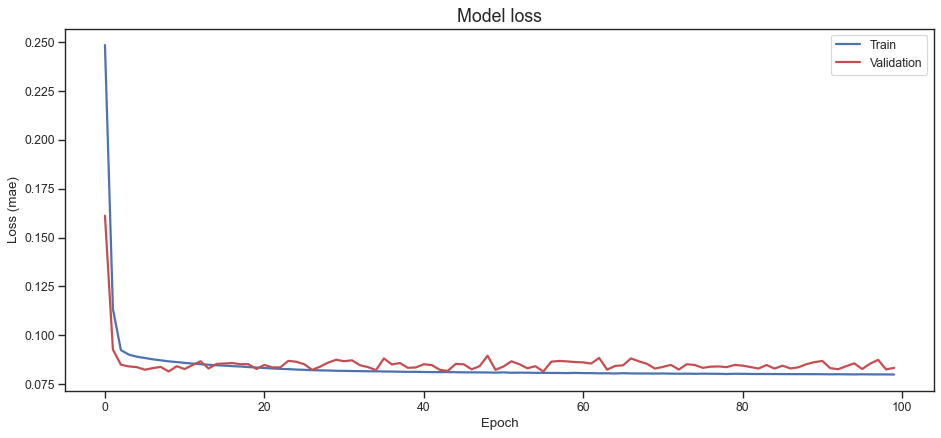

In [339]:
# Plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

C:\Users\jpayn\anaconda3\envs\pdm\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

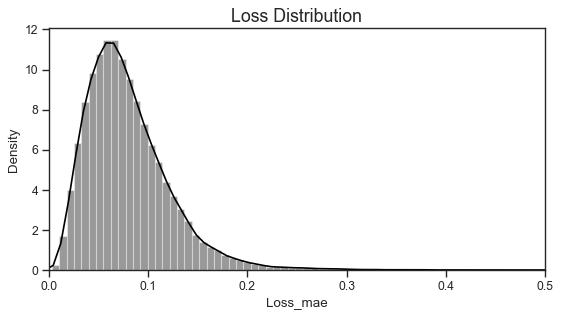

In [340]:
# Plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=df_train.columns)
X_pred.index = df_train.index

scored = pd.DataFrame(index=df_train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(8, 4), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 200, kde= True, color = 'black');
plt.xlim([0.0, 0.5])

In [341]:
def calc_test_loss(test, test_df, thresh):
    # Calculate the loss on the test set 1
    X_pred = model.predict(test)
    X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
    X_pred = pd.DataFrame(X_pred, columns=test_df.columns)
    X_pred.index = test_df.index

    scored = pd.DataFrame(index=test_df.index)
    Xtest = test.reshape(test.shape[0], test.shape[2])
    scored['loss_mae'] = np.mean(np.abs(X_pred - Xtest), axis=1)
    scored['threshold'] = thresh
    scored['prediction'] = (scored['loss_mae'] > scored['threshold']).astype(int)
    scored[backdrop_chan] = test_df[backdrop_chan]
    print(scored.head())
    return(scored)

In [342]:
# Calculate the loss on the test set 1
selected_threshold = 0.22
scored1 = calc_test_loss(X_test1, df_test1_df, selected_threshold)
scored2 = calc_test_loss(X_test2, df_test2_df, selected_threshold)
scored3 = calc_test_loss(X_test3, df_test3_df, selected_threshold)

                     loss_mae  threshold  prediction  sensor_04
timestamp                                                      
2018-04-11 21:55:00  0.175519       0.22           0   0.487466
2018-04-11 21:56:00  0.154375       0.22           0   0.328369
2018-04-11 21:57:00  0.161526       0.22           0   0.322744
2018-04-11 21:58:00  0.160328       0.22           0   0.328369
2018-04-11 21:59:00  0.161803       0.22           0   0.387026
                     loss_mae  threshold  prediction  sensor_04
timestamp                                                      
2018-04-12 21:55:00  1.329459       0.22           1  -2.694621
2018-04-18 00:30:00  1.019509       0.22           1  -2.670234
2018-05-19 03:18:00  0.613281       0.22           1  -2.711354
2018-05-25 00:30:00  0.146158       0.22           0   0.149184
2018-06-28 22:00:00  2.276509       0.22           1  -2.702656
                     loss_mae  threshold  prediction  sensor_04
timestamp                               

In [343]:
# Calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=df_train_df.columns)
X_pred_train.index = df_train_df.index

scored_train = pd.DataFrame(index=df_train_df.index)
scored_train['loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['threshold'] = selected_threshold
scored_train['prediction'] = (scored_train['loss_mae'] > scored_train['threshold']).astype(int)
scored_train[backdrop_chan] = df_train[backdrop_chan]

preds_lstma = pd.concat([scored_train, scored1, scored2, scored3])
preds_lstma = preds_lstma.sort_index()
preds_lstma['timestamp'] = preds_lstma.index
preds_lstma

,loss_mae,threshold,prediction,sensor_04,timestamp
timestamp,,,,,
2018-04-01 00:00:00,0.037427,0.22,0,0.303460,2018-04-01 00:00:00
2018-04-01 00:01:00,0.037427,0.22,0,0.303460,2018-04-01 00:01:00
2018-04-01 00:02:00,0.058398,0.22,0,0.334797,2018-04-01 00:02:00
2018-04-01 00:03:00,0.038600,0.22,0,0.260070,2018-04-01 00:03:00
2018-04-01 00:04:00,0.040830,0.22,0,0.317923,2018-04-01 00:04:00
...,...,...,...,...,...
2018-08-31 23:55:00,0.081875,0.22,0,0.305870,2018-08-31 23:55:00
2018-08-31 23:56:00,0.074898,0.22,0,0.279354,2018-08-31 23:56:00
2018-08-31 23:57:00,0.073538,0.22,0,0.244803,2018-08-31 23:57:00


In [344]:
# Create a subset dataset of anomalies
b = preds_lstma.loc[preds_lstma['prediction'] == 1, ['timestamp', 'threshold', 'loss_mae', backdrop_chan]] #

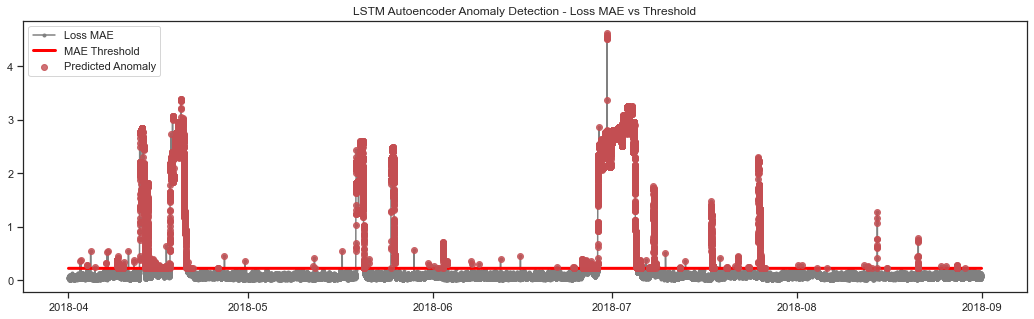

In [345]:
# Create visualisation of loss vs threshold through time
sns.set_style('ticks')
fig, ax = plt.subplots(figsize = (18, 5))
ax.plot(preds_lstma['loss_mae'], color='grey', marker = '.', zorder=1, label = 'Loss MAE')
ax.plot(preds_lstma['threshold'], color='red', marker = None, linewidth=3, zorder=2, label = 'MAE Threshold')
ax.scatter(b['timestamp'], b['loss_mae'], facecolors='r', edgecolors='r', marker='o', alpha=0.8, zorder=3, label = 'Predicted Anomaly')
plt.title('LSTM Autoencoder Anomaly Detection - Loss MAE vs Threshold')
ax.legend(loc = 'upper left')  
plt.show()

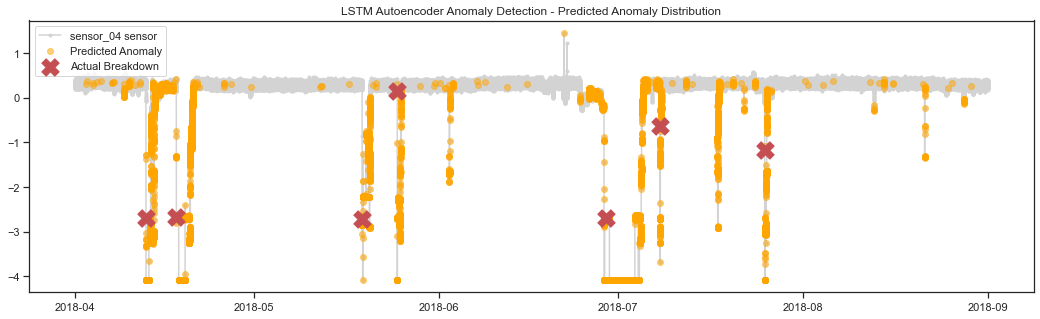

In [346]:
# Create visualisation of anomaly detection through time
fig, ax = plt.subplots(figsize = (18, 5))
ax.plot(preds_lstma.index, preds_lstma[backdrop_chan], color='lightgrey', marker = '.', zorder=1, label = f'{backdrop_chan} sensor')
ax.scatter(b['timestamp'], b[backdrop_chan], facecolors='orange', edgecolors='orange', marker='o', alpha=0.5, zorder=3, label = 'Predicted Anomaly')
ax.scatter(test2_rows['timestamp'], test2_rows[backdrop_chan], color='r', marker='X', s = 300, zorder=4, label = 'Actual Breakdown')
plt.title('LSTM Autoencoder Anomaly Detection - Predicted Anomaly Distribution')
ax.legend(loc = 'upper left')  
plt.show()

In [347]:
train_rows = preds_lstma.loc[preds_lstma.index.isin(df_train.index),:]
fp_per = round(100*sum(train_rows.prediction)/len(train_rows), 2)
print(f'Found {"{:,}".format(sum(test1_rows.prediction))} anomalies in normal zones (FP: {fp_per}%)')

Found 5,669 anomalies in normal zones (FP: 1.09%)


In [348]:
test1_rows = preds_lstma.loc[preds_lstma.index.isin(df_test1.index),:]
an_per = round(100*sum(test1_rows.prediction)/len(test1_rows), 2)
print(f'Found {"{:,}".format(sum(test1_rows.prediction))} anomalies in transition zones ({an_per}% coverage)')

Found 5,228 anomalies in transition zones (25.93% coverage)


In [349]:
test2_rows = preds_lstma.loc[preds_lstma.index.isin(df_test2.index),:]
print(f'Found {sum(test2_rows.prediction)} of {len(test2_rows)} breakdown events')

Found 6 of 7 breakdown events


In [350]:
test3_rows = preds_lstma.loc[preds_lstma.index.isin(df_test3.index),:]
an_per = round(100*sum(test3_rows.prediction)/len(test3_rows), 2)
print(f'Found {"{:,}".format(sum(test3_rows.prediction))} anomalies in recovery zones ({an_per}% coverage)')

Found 14,477 anomalies in recovery zones (100.0% coverage)


NameError: name 'preds_lstma' is not defined

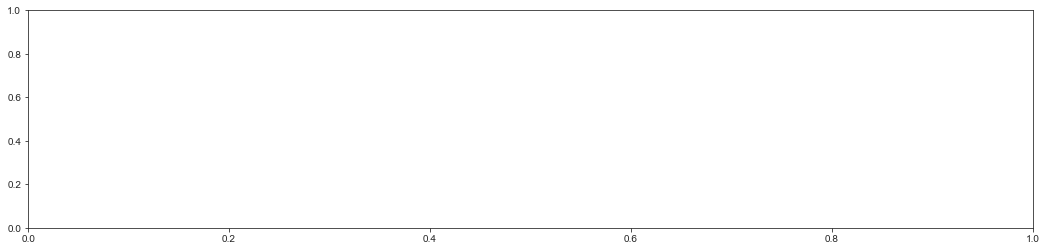

In [493]:
"""
Zoom in on each breakdown period & examine distance in lead up to 
the reporting of the machine as 'broken'
""" 
start_slice = [ # Start times for zoomed views
    pd.to_datetime('2018-04-10 00:00:00', format = '%Y-%m-%d %H:%M:%S'), 
    pd.to_datetime('2018-05-17 00:00:00', format = '%Y-%m-%d %H:%M:%S'), 
    pd.to_datetime('2018-06-25 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-07-23 00:00:00', format = '%Y-%m-%d %H:%M:%S')
]
ender_slice = [ # End times for zoomed views
    pd.to_datetime('2018-04-20 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-05-29 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-07-11 00:00:00', format = '%Y-%m-%d %H:%M:%S'),
    pd.to_datetime('2018-07-29 00:00:00', format = '%Y-%m-%d %H:%M:%S')
]
# Loop through and plot each zoomed view
for i in range(4):
    fig, ax = plt.subplots(figsize = (18, 4))
    ax.plot(preds_lstma.index, preds_lstma[backdrop_chan], color='lightgrey', marker = '.', zorder=1, label = f'{backdrop_chan} sensor')
    ax.scatter(b['timestamp'], b[backdrop_chan], facecolors='orange', edgecolors='orange', marker='o', alpha=0.5, zorder=4, label = 'Predicted Anomaly')
    ax.scatter(test2_rows['timestamp'], test2_rows[backdrop_chan], color='r', marker='X', s = 300, zorder=3, label = 'Actual Breakdown')
    ax.legend(loc = 'lower right')
    ax.set_xlim(start_slice[i], ender_slice[i]),
    plt.title(f'LSTM Autoencoder Anomaly Detection - {start_slice[i]} to {ender_slice[i]}')
    plt.show()